In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import image.modelsCNN as modelsCNN

import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN,MiniBatchKMeans,AgglomerativeClustering
from sklearn import metrics
from sklearn import discriminant_analysis

import anndata as ad
import gc

In [2]:
#load pretrained GAE
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
use_cuda=True

#load pretrained GAE
testepoch=9420

maskedgeName='knn20_connectivity'
hidden1=6000 #Number of units in hidden layer 1
hidden2=6000 #Number of units in hidden layer 2
# hidden3=2048
# hidden4=2048
# hidden5=128
fc_dim1=6000
# fc_dim2=128
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# clf_hidden=256
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
XreconWeight=20
# clfweight=20
advWeight=2
# randFeatureSubset=None
model_strGAE='gcn_vae_xa_e2_d1_dca'
protein=None #'scaled_binary'
proteinWeights=0.001
adj_decodeName=None #gala or None
ridgeL=0.01
shareGenePi=True

diamThresh_mul=800
minThresh_mul=12
overlap=int(diamThresh_mul*0.7)
areaThresh=diamThresh_mul*diamThresh_mul*0.7

num_features=2112
training_samples=['disease13','control13','disease8','control8']
training_sample_X='logminmax'
standardizeX=False
# name='allk20XA_01_dca_noD8' ###rename and retrain D8 C8
name='allnoC8k20XA_02_dca_over'
modelsavepath='/mnt/external_ssd/xinyi/models/train_gae_starmap/'+name
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
savedir=os.path.join('/home/xinyiz/starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
if training_sample_X in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in sampleidx.keys():
        featureslist[s+'X_'+'corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']==sampleidx[s]])
        featureslist[s+'X_'+'scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']==sampleidx[s]])

else:
    scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in sampleidx.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==sampleidx[s]]

        if training_sample_X=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        elif training_sample_X=='logminmax10':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler(feature_range=(0,10))
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
cellCoord={}
for s in sampleidx.keys():
    sampleidx_s=sampleidx[s] 
    cellCoord[s]=((scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy())/0.3).astype(int)

adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

adjnormlist={}
pos_weightlist={}
normlist={}
for ai in adj_list.keys():
    adjnormlist[ai]=preprocessing.preprocess_graph(adj_list[ai])
    
    pos_weightlist[ai] = torch.tensor(float(adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) / adj_list[ai].sum()) #using full unmasked adj
    normlist[ai] = adj_list[ai].shape[0] * adj_list[ai].shape[0] / float((adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) * 2)
    
    adj_label=adj_list[ai] + sp.eye(adj_list[ai].shape[0])
    adj_list[ai]=torch.tensor(adj_label.todense())
                
            

if model_strGAE=='gcn_vae_xa_e2_d1_dca':
    modelgae = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE
modelgae.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))

if use_cuda:
    modelgae.cuda()



0
0
0
0


In [3]:
features_raw_list={}
if 'dca' in model_strGAE:
    rawdata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
    features_raw_list={}
    for s in sampleidx.keys():
#         features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]]).cuda()
        features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]])

In [4]:
gaeClusterPath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/allk20XA_02_dca_over/combinedlogminmax_beforeAct/cluster/leiden_nn10mdist025n_pcs40res0.1epoch9990'
with open(gaeClusterPath, 'rb') as input:
    gaeclusterlabels = pickle.load(input)


In [5]:

ifplot=True
ifcluster=True

inverseAct=None
# inverseAct=None
plottype='umap'
pca=PCA()
minCells=15 #min number of cells for analysis
# clustermethod=['kmeanbatch']
clustermethod=['leiden','agglomerative','kmeanbatch']
# clustermethod=['leiden']
#umap/leiden clustering parameters
n_neighbors=10
min_dist=0.25
n_pcs=40 #for clustering
# resolution=[0.5,0.8,1,1.5]
resolution=[0.05,0.1,0.2,0.3,0.5,0.8,1,1.5]
plotepoch=1180
savenameAdd=''
#DBscan
epslist= [6,8,10]
min_sampleslist=[15,30,45] 
#agglomerative
nclusterlist=[2,3,4,5,8,10,15]
aggMetric=['euclidean']


combineCelltype={'glia':['Astro','Micro', 'OPC', 'Oligo'],'CA':['CA1', 'CA2', 'CA3']}


fastmode=False #Validate during training pass
seed=3
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
fc_dim1=96*5*5
fc_dim2=6000
# hidden1=64 #Number of channels in hidden layer 1
# hidden2=128 
# hidden3=256
# hidden4=512
# hidden5=512
# fc_dim1=512*25*25
# fc_dim2=1024
# # fc_dim3=128
# # fc_dim4=128
# # gcn_dim1=2600
# adv_hidden=128

model_str='cnn_vae'
targetBatch=None
diamThresh_mul=160
minThresh_mul=12
overlap=int(diamThresh_mul*0.5)
name='allnoC8_thresh25_02_mse100_sm5x'
logsavepath='/mnt/external_ssd/xinyi/log/train_jointGAEcnn_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_jointGAEcnn_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_jointGAEcnn_starmap/'+name
# modelsavepath='/mnt/external_ssd/xinyi/models/train_cnn_starmap/'+name
# plotsavepath='/mnt/external_ssd/xinyi/plots/train_cnn_starmap/'+name

#Load data
plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'    

In [6]:
# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True


In [7]:
# Create model
if model_str=='cnn_vae':
    model = modelsCNN.CNN_VAE(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
if model_str=='cnn_vae_alexnet':
    model = modelsCNN.CNN_VAE_alexnet(fc_dim1)      
if use_cuda:
    model.cuda()    
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(plotepoch)+'.pt')))


<All keys matched successfully>

In [8]:
np.random.seed(seed)
def plotembeddingbyCT(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd=''):
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1
        
    colortest=sns.color_palette("husl", celltypes.size)
#     np.random.shuffle(colortest)
    fig, ax = plt.subplots(dpi=400)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
#             np.random.randn(np.sum(idx)),
            embedding[idx, plotdimy],
            color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
            )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
#     ax.legend(ncol=3)
    plt.title(plotname+' embedding', fontsize=24)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'_components'+str(plotdimx)+str(plotdimy)+'.jpg'))
#     plt.show()
    
#     fig.clf()
    plt.close('all')
    
    gc.collect()

In [9]:
np.random.seed(seed)
def plotembeddingbyCT_3d(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,plotdimz=2,savenameAdd=''):
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1
        
    colortest=sns.color_palette("husl", celltypes.size)
#     np.random.shuffle(colortest)
#     fig, ax = plt.subplots(dpi=400)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            embedding[idx, plotdimz],
            color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
            )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
#     ax.legend(ncol=3)
    plt.title(plotname+' embedding', fontsize=24)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'_components'+str(plotdimx)+str(plotdimy)+str(plotdimz)+'.jpg'))
#     plt.show()
    
#     fig.clf()
    plt.close('all')
    
    gc.collect()

In [10]:
np.random.seed(seed)
def plotembeddingbyCT_shape(ctlist,samplelist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd=''):
    celltypes=np.unique(ctlist)
    sampletypes=np.unique(samplelist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1
        
    colortest=sns.color_palette("husl", celltypes.size)
    sampleShapelist=['o','^']
#     np.random.shuffle(colortest)
    fig, ax = plt.subplots(dpi=400)
    for st_idx in range(sampletypes.size):
        st=sampletypes[st_idx]
        idx_st=samplelist==st
        for ct in celltypes:
            if ct in excludelist:
                continue
            idx_ct=(ctlist==ct)
            idx=np.logical_and(idx_st,idx_ct)
            ax.scatter(
                embedding[idx, plotdimx],
                embedding[idx, plotdimy],
                color=colortest[celltypes_dict[ct]],marker=sampleShapelist[st_idx],label=ct+st,s=0.8,alpha=0.5
                )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
#     ax.legend(ncol=3)
#     plt.title(plotname+' embedding', fontsize=24)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'_components'+str(plotdimx)+str(plotdimy)+'.jpg'))
#     plt.show()
    
#     fig.clf()
    plt.close('all')
    
    gc.collect()

In [11]:
np.random.seed(seed)
def plotembeddingbyCT_contrast(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',maxplot=None): 
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1

    colortest=sns.color_palette("tab10")
    if not os.path.exists(os.path.join(savepath)):
        os.makedirs(savepath)

    for ct in celltypes:
        if maxplot and int(ct)>maxplot:
            continue
        fig, ax = plt.subplots()
        if ct == 'Unassigned':
            continue

        idx=(ctlist!=ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[1],label='others',s=1,alpha=0.5
            )

        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[0],label=ct,s=3,alpha=0.5
            )

        plt.gca().set_aspect('equal', 'datalim')
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax.legend()
        plt.title(plotname+' embedding', fontsize=24)
        plt.gcf().savefig(os.path.join(savepath,savename+'_'+str(ct)+savenameAdd+'.jpg'))
#         plt.show()
#         nplot+=1
        
    
#         fig.clf()
        plt.close('all')
        gc.collect()

In [12]:
np.random.seed(seed)
def inverseLeakyRelu(v,slope=0.01):
    vnegidx=(v<0)
    v[vnegidx]=1/slope*v[vnegidx]
    return v

In [13]:
np.random.seed(seed)
def clusterLeiden_single(inArray,n_neighbors,n_pcs,min_dist,resolution,randseed=seed):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    adata=ad.AnnData(inArray)
    scanpy.tl.pca(adata, svd_solver='arpack')
    scanpy.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    scanpy.tl.umap(adata,min_dist=min_dist,random_state=randseed)
    scanpy.tl.leiden(adata,resolution=resolution,random_state=randseed)
    return adata.obs['leiden'].to_numpy()

def clusterLeiden(inArray,n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np,randseed=seed):
    for r in resolution:
        clusterRes=clusterLeiden_single(inArray,n_neighbors,n_pcs,min_dist,r,randseed=seed)
#         print(clusterRes.shape)
        savenamecluster='leiden_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'n_pcs'+str(n_pcs)+'res'+str(r)+'epoch'+str(plotepoch)
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'leiden',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'leiden',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s,savenameAdd=savenamecluster)

        plotembeddingbyCT(clusterRes,'leiden_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'leiden_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)

def clusterLeiden_allsample(embedding,savedir,clustersavedir,inArray,n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np,samplenameList,randseed=seed):
    for r in resolution:
        clusterRes=clusterLeiden_single(inArray,n_neighbors,n_pcs,min_dist,r,randseed=seed)
        savenamecluster='leiden_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'n_pcs'+str(n_pcs)+'res'+str(r)+'epoch'+str(plotepoch)
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'leiden',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'leiden',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

        for s in plot_samples.keys():
            sidx=(samplenameList==s)
            plotembeddingbyCT(clusterRes[sidx],'leiden_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes[sidx],'leiden_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)

         

In [14]:
np.random.seed(seed)
def clusterDBscan_single(inArray,eps,min_samples,n_pcs):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    inArray=pca.fit_transform(inArray)
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(inArray[:,:n_pcs])
#     db = DBSCAN(eps=eps, min_samples=min_samples).fit(inArray[:,:n_pcs])
#     core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#     core_samples_mask[db.core_sample_indices_] = True
#     labels = db.labels_
    return labels

def clusterDBscan(inArray,epsL,min_samplesL,n_pcs,sobj_coord_np):
    for eps in epsL:
        for min_samples in min_samplesL:
            clusterRes=clusterDBscan_single(inArray,eps,min_samples,n_pcs)
    #         print(clusterRes.shape)
            savenamecluster='dbscan_eps'+str(eps)+'msamples'+str(min_samples)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
            plotembeddingbyCT(clusterRes,'dbscan',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'dbscan',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s,savenameAdd=savenamecluster)

            plotembeddingbyCT(clusterRes,'dbscan_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'dbscan_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)

def clusterDBscan_allsample(embedding,savedir,clustersavedir,inArray,epsL,min_samplesL,n_pcs,sobj_coord_np,samplenameList):
    for eps in epsL:
        for min_samples in min_samplesL:
            clusterRes=clusterDBscan_single(inArray,eps,min_samples,n_pcs)
            savenamecluster='dbscan_eps'+str(eps)+'msample'+str(min_samples)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
            plotembeddingbyCT(clusterRes,'dbscan',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'dbscan',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

            for s in plot_samples.keys():
                sidx=(samplenameList==s)
                plotembeddingbyCT(clusterRes[sidx],'dbscan_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster)
                plotembeddingbyCT_contrast(clusterRes[sidx],'dbscan_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)


In [15]:
np.random.seed(seed)
def clusterAgg_single(inArray,ncluster,aggmetric,n_pcs):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    inArray=pca.fit_transform(inArray)
    labels = AgglomerativeClustering(n_clusters=ncluster,affinity=aggmetric).fit_predict(inArray[:,:n_pcs])
#     labels = agg.labels_
    return labels

def clusterAgg(inArray,nclusterL,aggmetricL,n_pcs,sobj_coord_np):
    for ncluster in nclusterL:
        for aggmetric in aggmetricL:
            clusterRes=clusterAgg_single(inArray,ncluster,aggmetric,n_pcs)
    #         print(clusterRes.shape)
            savenamecluster='agg_ncluster'+str(ncluster)+aggmetric+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
            plotembeddingbyCT(clusterRes,'agg',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'agg',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s,savenameAdd=savenamecluster)

            plotembeddingbyCT(clusterRes,'agg_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'agg_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)

def clusterAgg_allsample(embedding,savedir,clustersavedir,inArray,nclusterL,aggmetricL,n_pcs,sobj_coord_np,samplenameList):
    for ncluster in nclusterL:
        for aggmetric in aggmetricL:
            clusterRes=clusterAgg_single(inArray,ncluster,aggmetric,n_pcs)
            savenamecluster='agg_ncluster'+str(ncluster)+aggmetric+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
            plotembeddingbyCT(clusterRes,'agg',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'agg',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

            for s in plot_samples.keys():
                sidx=(samplenameList==s)
                plotembeddingbyCT(clusterRes[sidx],'agg_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster)
                plotembeddingbyCT_contrast(clusterRes[sidx],'agg_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)


In [16]:
np.random.seed(seed)
def clusterMinibatchKmean_single(inArray,ncluster,n_pcs,batchsize=100):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    batchsize=int(np.min([(inArray.shape[0]-1)/3,(inArray.shape[1]-1)/3,batchsize]))
    inArray=pca.fit_transform(inArray)
    labels = MiniBatchKMeans(n_clusters=ncluster,random_state=seed,batch_size=batchsize).fit_predict(inArray[:,:n_pcs])
    return labels

def clusterMinibatchKmean(inArray,nclusterL,n_pcs,sobj_coord_np):
    for ncluster in nclusterL:
        clusterRes=clusterMinibatchKmean_single(inArray,ncluster,n_pcs)
#         print(clusterRes.shape)
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'minibatchkmean',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'minibatchkmean',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s,savenameAdd=savenamecluster)

        plotembeddingbyCT(clusterRes,'minibatchkmean_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'minibatchkmean_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)

def clusterMinibatchKmean_allsample(embedding,savedir,clustersavedir,inArray,nclusterL,n_pcs,sobj_coord_np,samplenameList):
    for ncluster in nclusterL:
        clusterRes=clusterMinibatchKmean_single(inArray,ncluster,n_pcs)
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'minibatchkmean',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'minibatchkmean',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

        for s in plot_samples.keys():
            sidx=(samplenameList==s)
            plotembeddingbyCT(clusterRes[sidx],'minibatchkmean_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes[sidx],'minibatchkmean_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)


In [17]:
#compute embeddings and translate
mulist={}
xlist={}
alist={}
model.eval()
batchsize=200
with torch.no_grad():
    for s in plot_samples.keys():
        training_samples_t=s
        imgInputnp=loadImage.load_cellCentroid(cellCoord[training_samples_t],sampleidx[training_samples_t],datadir,diamThresh_mul,ifFlip=False,seed=3,imagename='pi_sum.tif',minmaxscale=True,nchannels=1)
        muplot_all=torch.zeros((imgInputnp.shape[0],fc_dim2)).cuda()
        for i in range(int(np.ceil(imgInputnp.shape[0]/batchsize))):
            idx=np.arange(imgInputnp.shape[0])[i*batchsize:min((i+1)*batchsize,imgInputnp.shape[0])]
            imgInput=imgInputnp[idx]
            if use_cuda:
                imgInput=torch.tensor(imgInput).cuda().float()
            recon,z, mu, logvar = model(imgInput)

            mu=mu.detach()
    #             if plotRecon:
    #                 if plotRecon=='meanRecon':
    #                     mu=features_recon[3].cpu().detach().numpy()
            muplot_all[idx]=mu
        xlist[s]=modelgae.decode_X(muplot_all)
        mulist[s]=muplot_all
        alist[s]=modelgae.dc(muplot_all)

(22210, 22344)
(22355, 18953)
(22294, 19552)
(22452, 19616)


In [18]:
#compute recon mean of ground truth
xlist_ref={}
for s in plot_samples.keys():
    adj=adj_list[s] 
    adj_norm = preprocessing.preprocess_graph(adj)
    adj_decode=None
    if adj_decodeName == 'gala':
        adj_decode=preprocessing.preprocess_graph_sharp(adj)
    for xcorr in ['logminmax']:
        samplename=s+'X_'+xcorr
        features=featureslist[samplename] 
        if standardizeX:
            features=torch.tensor(scale(features,axis=0, with_mean=True, with_std=True, copy=True))
        if use_cuda:
            modelgae.cuda()
            features = features.cuda().float()
            adj_norm=adj_norm.cuda()
            if adj_decodeName:
                adj_decode=adj_decode.cuda()
        
        modelgae.eval()
        if adj_decodeName==None:
            adj_recon,mu,logvar,z, features_recon = modelgae(features, adj_norm)
        else:
            adj_recon,mu,logvar,z, features_recon = modelgae(features, adj_norm,adj_decode)
        xlist_ref[s]=features_recon

0
0
0
0


In [19]:
plotsavepath

'/mnt/external_ssd/xinyi/plots/train_jointGAEcnn_starmap/allnoC8_thresh25_02_mse100_sm5x'

In [20]:
with open(os.path.join(plotsavepath,'pred'),'wb') as output:
    pickle.dump(xlist,output)

In [21]:
with open(os.path.join(plotsavepath,'true'),'wb') as output:
    pickle.dump(xlist_ref,output)

In [17]:
with open(os.path.join(plotsavepath,'pred'),'rb') as output:
    xlist=pickle.load(output)

In [18]:
with open(os.path.join(plotsavepath,'true'),'rb') as output:
    xlist_ref=pickle.load(output)

In [20]:
coordlist=cellCoord

In [21]:
samplenameList=None

for s in plot_samples.keys():
    if samplenameList is None:
        samplenameList=np.repeat(s,xlist_ref[s][3].detach().cpu().numpy().shape[0])
    else:
        samplenameList=np.concatenate((samplenameList,np.repeat(s,xlist_ref[s][3].detach().cpu().numpy().shape[0])),axis=None)

In [25]:
celltype_broad=np.array([])
for s in plot_samples.keys():
    celltype_broad=np.concatenate((celltype_broad,scaleddata.obs.loc[scaleddata.obs['sample']==plot_samples[s],'top_level']))


In [23]:
#compute X & A loss
for s in plot_samples.keys():
    print(s)
    train_nodes_idx=np.arange(featureslist[s+'X_'+training_sample_X].shape[0])
    loss_x_train=loss_x(xlist[s], featureslist[s+'X_'+training_sample_X].cuda(0).float(),train_nodes_idx,XreconWeight,ridgeL,features_raw_list[s+'X_'+'raw'].cuda().float())
    print(loss_x_train.item())
    loss_a_train=loss_a(alist[s], adj_list[s].cuda(0).float(), pos_weightlist[ai], normlist[ai],train_nodes_idx)
    print(loss_a_train.item())

disease13
1.4465845823287964
0.6211054921150208
control13
1.3227391242980957
0.6734606623649597
disease8
1.2614518404006958
0.7150726914405823
control8
1.3969085216522217
0.6720635294914246


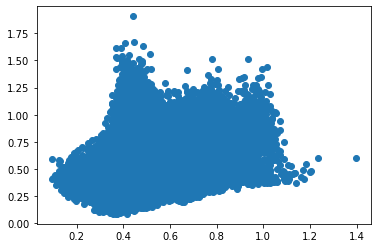

In [24]:
plt.rcParams['agg.path.chunksize'] = 10000
plt.scatter(xlist_ref['control8'][3].detach().cpu().numpy().flatten(),xlist['control8'][3].detach().cpu().numpy().flatten())

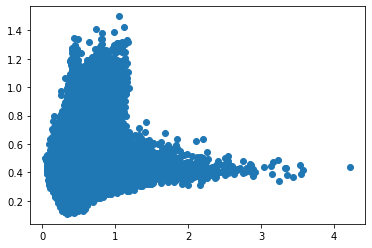

In [25]:
plt.scatter(xlist_ref['control13'][3].detach().cpu().numpy().flatten(),xlist['control13'][3].detach().cpu().numpy().flatten())

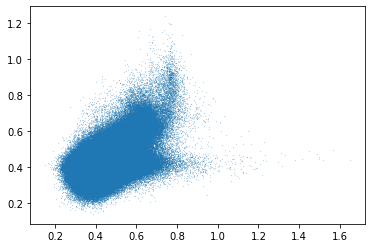

In [30]:
plt.scatter(xlist_ref['control13'][3].detach().cpu().numpy()[gaeclusterlabels[samplenameList=='control13']=='0'].flatten(),xlist['control13'][3].detach().cpu().numpy()[gaeclusterlabels[samplenameList=='control13']=='0'].flatten(),s=0.01)

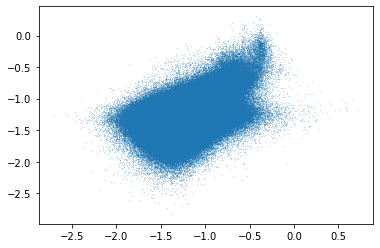

In [31]:
plt.scatter(np.log2(xlist_ref['control13'][3].detach().cpu().numpy()[gaeclusterlabels[samplenameList=='control13']=='0'].flatten()),np.log2(xlist['control13'][3].detach().cpu().numpy()[gaeclusterlabels[samplenameList=='control13']=='0'].flatten()),s=0.01)

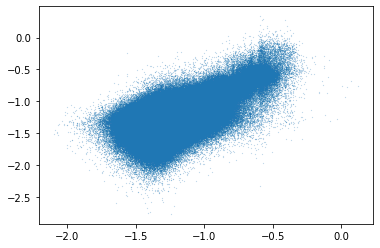

In [32]:
plt.scatter(np.log2(xlist_ref['control8'][3].detach().cpu().numpy()[gaeclusterlabels[samplenameList=='control8']=='0'].flatten()),np.log2(xlist['control8'][3].detach().cpu().numpy()[gaeclusterlabels[samplenameList=='control8']=='0'].flatten()),s=0.01)

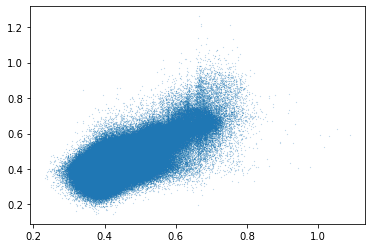

In [33]:
plt.scatter((xlist_ref['control8'][3].detach().cpu().numpy()[gaeclusterlabels[samplenameList=='control8']=='0'].flatten()),(xlist['control8'][3].detach().cpu().numpy()[gaeclusterlabels[samplenameList=='control8']=='0'].flatten()),s=0.01)

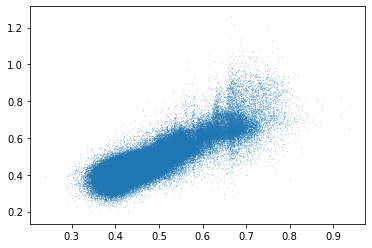

In [34]:
exprsthresh=features_raw_list['control8X_raw']>0
clusteridx=gaeclusterlabels[samplenameList=='control8']=='0'
plt.scatter((xlist_ref['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),(xlist['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),s=0.01)

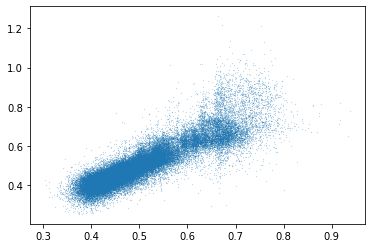

In [35]:
exprsthresh=features_raw_list['control8X_raw']>1
clusteridx=gaeclusterlabels[samplenameList=='control8']=='0'
plt.scatter((xlist_ref['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),(xlist['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),s=0.01)

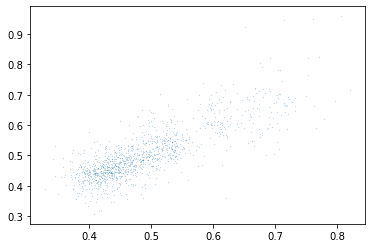

In [38]:
exprsthresh=features_raw_list['control8X_raw']>1
clusteridx=gaeclusterlabels[samplenameList=='control8']=='0'
ctidx=celltype_broad[samplenameList=='control8']=='Micro'
clusteridx=np.logical_and(clusteridx,ctidx)
plt.scatter((xlist_ref['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),(xlist['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),s=0.01)

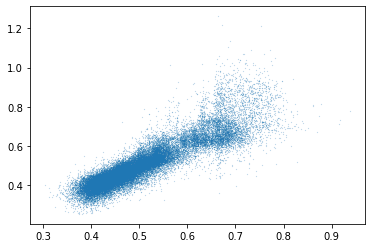

In [39]:
exprsthresh=features_raw_list['control8X_raw']>1
clusteridx=gaeclusterlabels[samplenameList=='control8']=='0'
ctidx=celltype_broad[samplenameList=='control8']=='Ex'
clusteridx=np.logical_and(clusteridx,ctidx)
plt.scatter((xlist_ref['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),(xlist['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),s=0.01)

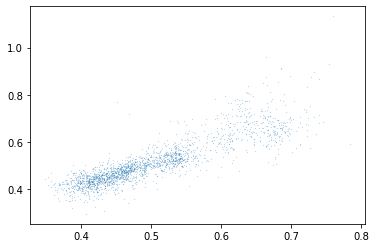

In [40]:
exprsthresh=features_raw_list['control8X_raw']>1
clusteridx=gaeclusterlabels[samplenameList=='control8']=='0'
ctidx=celltype_broad[samplenameList=='control8']=='Oligo'
clusteridx=np.logical_and(clusteridx,ctidx)
plt.scatter((xlist_ref['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),(xlist['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),s=0.01)

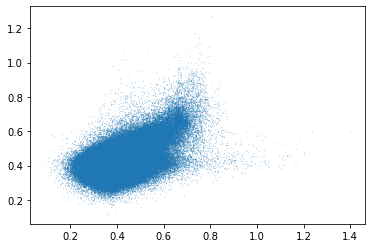

In [41]:
plt.scatter((xlist_ref['control8'][3].detach().cpu().numpy()[gaeclusterlabels[samplenameList=='control8']=='1'].flatten()),(xlist['control8'][3].detach().cpu().numpy()[gaeclusterlabels[samplenameList=='control8']=='1'].flatten()),s=0.01)

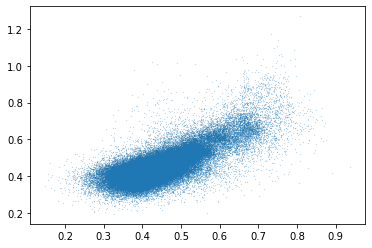

In [42]:
exprsthresh=features_raw_list['control8X_raw']>0
clusteridx=gaeclusterlabels[samplenameList=='control8']=='1'
plt.scatter((xlist_ref['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),(xlist['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),s=0.01)

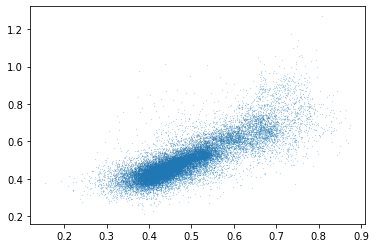

In [43]:
exprsthresh=features_raw_list['control8X_raw']>1
clusteridx=gaeclusterlabels[samplenameList=='control8']=='1'
plt.scatter((xlist_ref['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),(xlist['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),s=0.01)

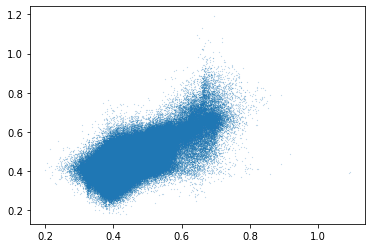

In [44]:
plt.scatter((xlist_ref['control8'][3].detach().cpu().numpy()[gaeclusterlabels[samplenameList=='control8']=='3'].flatten()),(xlist['control8'][3].detach().cpu().numpy()[gaeclusterlabels[samplenameList=='control8']=='3'].flatten()),s=0.01)

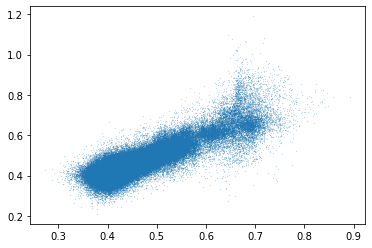

In [45]:
exprsthresh=features_raw_list['control8X_raw']>0
clusteridx=gaeclusterlabels[samplenameList=='control8']=='3'
plt.scatter((xlist_ref['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),(xlist['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),s=0.01)

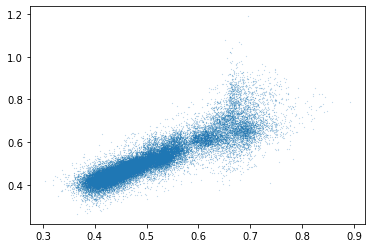

In [46]:
exprsthresh=features_raw_list['control8X_raw']>1
clusteridx=gaeclusterlabels[samplenameList=='control8']=='3'
plt.scatter((xlist_ref['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),(xlist['control8'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),s=0.01)

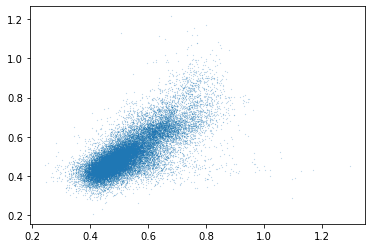

In [47]:
exprsthresh=features_raw_list['control13X_raw']>1
clusteridx=gaeclusterlabels[samplenameList=='control13']=='3'
plt.scatter((xlist_ref['control13'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),(xlist['control13'][3].detach().cpu().numpy()[clusteridx][exprsthresh[clusteridx]].flatten()),s=0.01)

In [22]:
predplot=None
refplot=None

for s in plot_samples.keys():
    samplename=s
    if predplot is None:
        predplot=xlist[samplename][3].cpu().detach().numpy() #use recon mean not orig features
    else:
        predplot=np.concatenate((predplot,xlist[samplename][3].cpu().detach().numpy()))

for s in plot_samples.keys():
    samplename=s
    if refplot is None:
        refplot=xlist_ref[samplename][3].cpu().detach().numpy() #use recon mean not orig features
    else:
        refplot=np.concatenate((refplot,xlist_ref[samplename][3].cpu().detach().numpy()))

In [35]:
feature_names=scaleddata.var.index
fc=1.1
pvalthresh=0.05
minCell_clusterDE=15
ntopgene=10
def de_singlesample(sample,labels,savepath,feature_names,plotOnly):
    if np.unique(labels).shape[0]==1:
        return
    var = pd.DataFrame(data=feature_names,index=feature_names,columns=['feature_names'])
    obs = pd.DataFrame()
    obs['clusterLabel']=labels
    adata = ad.AnnData(sample, obs=obs.astype('category'),var=var.astype('category'))
    if not plotOnly:
        scanpy.tl.rank_genes_groups(adata, 'clusterLabel',use_raw=False, method='wilcoxon',pts=True)
        with open(os.path.join(savepath), 'wb') as output:
            pickle.dump(adata.uns['rank_genes_groups'], output, pickle.HIGHEST_PROTOCOL)
    else:
        with open(os.path.join(savepath), 'rb') as input:
            adata.uns['rank_genes_groups']=pickle.load(input)
#     scanpy.tl.filter_rank_genes_groups(adata,groupby='clusterLabel',use_raw=False, min_fold_change=fc,min_in_group_fraction=minIngroup,max_out_group_fraction=maxOutgroup)
    genelist=np.array([])
#     print(adata.obs['clusterLabel'])
    for l in np.unique(labels).astype(str):
        print(l)
        if l==-1:
            continue
        if np.sum(labels.astype(str)==l)<minCell_clusterDE or np.sum(labels.astype(str)!=l)<minCell_clusterDE:
            continue
        resl=scanpy.get.rank_genes_groups_df(adata, group=l,pval_cutoff=pvalthresh,gene_symbols='feature_names')
#         print(resl)
        reslup=resl[resl['logfoldchanges']>np.log2(fc)]
        resldown=resl[resl['logfoldchanges']< -np.log2(fc)]
        resl=resl[np.logical_or(resl['logfoldchanges']>np.log2(fc),resl['logfoldchanges']< -np.log2(fc))]
        np.savetxt(savepath+'UP_'+str(l)+'_fc'+str(fc)+'pvalue'+str(pvalthresh)+'.csv',np.array(reslup['names']).reshape((-1,1)),fmt='%s')
        np.savetxt(savepath+'Down_'+str(l)+'_fc'+str(fc)+'pvalue'+str(pvalthresh)+'.csv',np.array(resldown['names']).reshape((-1,1)),fmt='%s')
#         resl=resl[resl['pts']>minIngroup]
        resl=resl.sort_values('pvals_adj',axis=0)
        resl=resl.iloc[:np.min([resl.shape[0],ntopgene]),:]
        genelist=np.concatenate((genelist,resl['names']))
    if genelist.shape[0]==0:
        print('noDE')
        return
    scanpy.pl.dotplot(adata,np.unique(genelist),groupby='clusterLabel',use_raw=False,return_fig =True).savefig(savepath+'fc'+str(fc)+'ntop'+str(ntopgene)+'pvalue'+str(pvalthresh)+'.jpg')
    return genelist
    #     return (np.array(reslup['names']),np.array(resldown['names']))

In [51]:
feature_names=scaleddata.var.index
feature_names=feature_names.astype(str)

In [60]:
featureDE=None
for s in plot_samples.keys():
    if featureDE is None:
        featureDE=np.copy(features_raw_list[s+'X_raw'])
    else:
        featureDE=np.concatenate((featureDE,features_raw_list[s+'X_raw']),axis=0)


In [ ]:
#cluster x recon mean
for s in plot_samples.keys():
    samplename=s
    sampledir=os.path.join(plotsavepath,samplename)
    clustersavedir=os.path.join(sampledir,'clustertranslation')
    if not os.path.exists(sampledir):
        os.mkdir(sampledir)
    if not os.path.exists(clustersavedir):
        os.mkdir(clustersavedir)
        
    muplot=np.copy(xlist[samplename][3].cpu().numpy())
    n_pcs=40
    batchsize=100
    muplot=pca.fit_transform(muplot)
    mulabel = MiniBatchKMeans(n_clusters=11,random_state=seed,batch_size=batchsize).fit_predict(muplot[:,:n_pcs])
    
    refplot=np.copy(featureslist[s+'X_'+training_sample_X].numpy())
    refplot=pca.fit_transform(refplot)
    reflabel = MiniBatchKMeans(n_clusters=11,random_state=seed,batch_size=batchsize).fit_predict(refplot[:,:n_pcs])
    
    savenamecluster='kmeans11'
    res=np.zeros((np.unique(mulabel).size,np.unique(reflabel).size))
    for li in range(res.shape[0]):
        l=np.unique(mulabel)[li]
        nl=np.sum(mulabel==l)
        reflabel_l=reflabel[mulabel==l]
        for ci in range(res.shape[1]):
            c=np.unique(reflabel)[ci]
            res[li,ci]=np.sum(reflabel_l==c)
#             res[li,ci]=np.sum(reflabel_l==c)/nl
    addname='byrow'
    for li in range(res.shape[0]):
        l=np.unique(mulabel)[li]
        nl=np.sum(mulabel==l)
        res[li]=res[li]/nl
#     else:
#         addname+='_normbyCT'
#         for ci in range(res.shape[1]):
#             c=np.unique(reflabel)[ci]
#             nc=np.sum(reflabel==c)
#             res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary')
    ax.set_yticks(np.arange(np.unique(mulabel).size))
    ax.set_yticklabels(np.unique(mulabel))
    ax.set_xticks(np.arange(np.unique(reflabel).size))
    ax.set_xticklabels(np.unique(reflabel))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(clustersavedir,savenamecluster+'_clusteragreement'+addname+'.jpg'))
    plt.close()

In [ ]:
#plot pred recon mean umap; color by orig recon mean clusters
nclusters=2
reflabel={}

for s in plot_samples.keys():
    samplename=s
    n_pcs=40
    batchsize=100
    refplot=xlist_ref[samplename][3].cpu().detach().numpy() #use recon mean not orig features
    refplot=pca.fit_transform(refplot)
    reflabel[s] = MiniBatchKMeans(n_clusters=nclusters,random_state=seed,batch_size=batchsize).fit_predict(refplot[:,:n_pcs])
#     reflabel[s]=clusterLeiden_single(refplot,n_neighbors,n_pcs,min_dist,0.05,randseed=seed)


In [ ]:
#umap/leiden clustering parameters
n_neighbors=20
min_dist=0.2

# combine all latents to one plot 
np.random.seed(seed)
latents=None
reflabellist=None
sobj_coord_np=None

for s in plot_samples.keys():
    sampleidx=plot_samples[s]        
    samplename=s+'X_logminmax'
#     muplot=xlist[s][3].cpu().numpy()
    muplot=xlist[s][3].cpu().detach().numpy()
    
    if latents is None:
        latents=muplot
        sobj_coord_np=coordlist[s]
        reflabellist=reflabel[s]
    else:
        latents=np.vstack((latents,muplot))
        sobj_coord_np=np.concatenate((sobj_coord_np,coordlist[s]),axis=0)
        reflabellist=np.concatenate((reflabellist,reflabel[s]))

# sampledir=os.path.join(plotsavepath,'combined'+'_clustertranslation_reconMean')
# savedir=os.path.join(sampledir,'embedding_'+plottype)
# clustersavedir=os.path.join(sampledir,'cluster')
# if not os.path.exists(sampledir):
#     os.mkdir(sampledir)
# if not os.path.exists(savedir):
#     os.mkdir(savedir)
# if not os.path.exists(clustersavedir):
#     os.mkdir(clustersavedir)

if plottype=='umap':
    reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed,n_components=3)
    embedding = reducer.fit_transform(latents)
    savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
elif plottype=='pca':
    embedding=pca.fit_transform(latents)
    savenameAdd='_epoch'+str(plotepoch)
if ifplot:
    plotembeddingbyCT(reflabellist,'reflabel',[],embedding,savedir,plottype+'of all samples',savenameAdd=savenameAdd,plotdimx=1,plotdimy=2)


In [378]:
#plot pred recon mean umap; color by orig recon mean clusters
#combinedCluster
# nclusters=2
# refplot=None

# for s in plot_samples.keys():
#     samplename=s
#     n_pcs=40
#     batchsize=100
#     if refplot is None:
#         refplot=xlist_ref[samplename][3].cpu().detach().numpy() #use recon mean not orig features
#     else:
#         refplot=np.concatenate((refplot,xlist_ref[samplename][3].cpu().detach().numpy()))
# refplot=pca.fit_transform(refplot)
# reflabel = MiniBatchKMeans(n_clusters=nclusters,random_state=seed,batch_size=batchsize).fit_predict(refplot[:,:n_pcs])
reflabel=clusterLeiden_single(refplot,n_neighbors,n_pcs,min_dist,0.1,randseed=seed)


In [379]:
np.unique(reflabel)

array(['0', '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype=object)

In [ ]:
#umap/leiden clustering parameters

n_neighbors=10
min_dist=0.2

# combine all latents to one plot 
np.random.seed(seed)
# latents=None
latents=predplot
sobj_coord_np=None
samplenameList=None

for s in plot_samples.keys():
    sampleidx=plot_samples[s]        
    samplename=s+'X_logminmax'
    muplot=xlist[s][3].cpu().numpy()
#     muplot=xlist_ref[s][3].cpu().detach().numpy()
    
    if samplenameList is None:
        sobj_coord_np=coordlist[s]
        samplenameList=np.repeat(s,muplot.shape[0])
    else:
        sobj_coord_np=np.concatenate((sobj_coord_np,coordlist[s]),axis=0)
        samplenameList=np.concatenate((samplenameList,np.repeat(s,muplot.shape[0])),axis=None)

sampledir=os.path.join(plotsavepath,'combined'+'_clustertranslation_reconMean')
savedir=os.path.join(sampledir,'embedding_'+plottype,'leiden')
clustersavedir=os.path.join(sampledir,'cluster')
if not os.path.exists(sampledir):
    os.mkdir(sampledir)
if not os.path.exists(savedir):
    os.mkdir(os.path.join(sampledir,'embedding_'+plottype))
    os.mkdir(savedir)
if not os.path.exists(clustersavedir):
    os.mkdir(clustersavedir)

if plottype=='umap':
    reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed,n_components=3)
    embedding = reducer.fit_transform(latents)
    savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
elif plottype=='pca':
    embedding=pca.fit_transform(latents)
    savenameAdd='_epoch'+str(plotepoch)
if ifplot:
    plotembeddingbyCT(reflabel,'reflabel',[],embedding,savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combinedCluster_res0.1',plotdimx=0,plotdimy=1)
    plotembeddingbyCT(samplenameList,'sample',[],embedding,savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combinedCluster_res0.1',plotdimx=0,plotdimy=1)


In [179]:
showclusters=['0','1','3']
plotclusters=['0','1','3']

In [178]:
#combine ref and pred in same umap 
#umap/leiden clustering parameters

n_neighbors=10
min_dist=0.2

# combine all latents to one plot 
np.random.seed(seed)
latents=None
reflabellist=None
# sobj_coord_np=None
samplenameList=None
predtruelist=None

for s in plot_samples.keys():
    sampleidx=plot_samples[s]        
    samplename=s+'X_logminmax'
    muplot=xlist[s][3].cpu().numpy()
#     muplot=xlist_ref[s][3].cpu().detach().numpy()
    
    if latents is None:
        latents=muplot
#         sobj_coord_np=coordlist[s]
        samplenameList=np.repeat(s,muplot.shape[0])
#         reflabellist=reflabel[s]
        predtruelist=np.repeat('pred',muplot.shape[0])
    else:
        latents=np.vstack((latents,muplot))
#         sobj_coord_np=np.concatenate((sobj_coord_np,coordlist[s]),axis=0)
        samplenameList=np.concatenate((samplenameList,np.repeat(s+'_pred',muplot.shape[0])),axis=None)
#         reflabellist=np.concatenate((reflabellist,reflabel[s]))
        predtruelist=np.concatenate((predtruelist,np.repeat('pred',muplot.shape[0])))

for s in plot_samples.keys():
    sampleidx=plot_samples[s]        
    samplename=s+'X_logminmax'
#     muplot=xlist[s][3].cpu().numpy()
    muplot=xlist_ref[s][3].cpu().detach().numpy()
    
    latents=np.vstack((latents,muplot))
#     sobj_coord_np=np.concatenate((sobj_coord_np,coordlist[s]),axis=0)
        
    samplenameList=np.concatenate((samplenameList,np.repeat(s+'_ref',muplot.shape[0])),axis=None)
    predtruelist=np.concatenate((predtruelist,np.repeat('true',muplot.shape[0])))
sampledir=os.path.join(plotsavepath,'combined'+'_clustertranslation_reconMean')
savedir=os.path.join(sampledir,'embedding_'+plottype,'leiden')
clustersavedir=os.path.join(sampledir,'cluster')
if not os.path.exists(sampledir):
    os.mkdir(sampledir)
if not os.path.exists(savedir):
    os.mkdir(savedir)
if not os.path.exists(clustersavedir):
    os.mkdir(clustersavedir)

if plottype=='umap':
    reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed,n_components=3)
    embedding = reducer.fit_transform(latents)
    savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
elif plottype=='pca':
    embedding=pca.fit_transform(latents)
    savenameAdd='_epoch'+str(plotepoch)
if ifplot:
    cnameadd=''
    cidx=np.repeat(False,gaeclusterlabels.size)
    for c in showclusters:
        cnameadd+=c
        cidx=np.logical_or(cidx,gaeclusterlabels==c)
        
    plotembeddingbyCT_shape(np.concatenate((reflabel[cidx],reflabel[cidx])),predtruelist[np.concatenate((cidx,cidx))],'reflabel',[],embedding[np.concatenate((cidx,cidx))],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_show'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT_shape(samplenameList[np.concatenate((cidx,cidx))],predtruelist[np.concatenate((cidx,cidx))],'sample',[],embedding[np.concatenate((cidx,cidx))],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_show'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT(reflabel[cidx],'reflabel',[],embedding[predtruelist=='pred'][cidx],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_pred_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_show'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT(samplenameList[predtruelist=='pred'][cidx],'sample',[],embedding[predtruelist=='pred'][cidx],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_pred_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_show'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT(reflabel[cidx],'reflabel',[],embedding[predtruelist=='true'][cidx],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_true_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_show'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT(samplenameList[predtruelist=='true'][cidx],'sample',[],embedding[predtruelist=='true'][cidx],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_true_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_show'+cnameadd,plotdimx=0,plotdimy=1)
    
    plotembeddingbyCT_shape(np.concatenate((gaeclusterlabels[cidx],gaeclusterlabels[cidx])),predtruelist[np.concatenate((cidx,cidx))],'gaecluster',[],embedding[np.concatenate((cidx,cidx))],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_show'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT(gaeclusterlabels[cidx],'gaecluster',[],embedding[predtruelist=='pred'][cidx],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_pred_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_show'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT(gaeclusterlabels[cidx],'gaecluster',[],embedding[predtruelist=='true'][cidx],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_true_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_show'+cnameadd,plotdimx=0,plotdimy=1)


In [182]:
#combine ref and pred in same umap -- only plot selected clusters
#umap/leiden clustering parameters

n_neighbors=10
min_dist=0.2

# combine all latents to one plot 
np.random.seed(seed)
latents=None
reflabellist=None
# sobj_coord_np=None
samplenameList=None
predtruelist=None

for s in plot_samples.keys():
    sampleidx=plot_samples[s]        
    samplename=s+'X_logminmax'
    muplot=xlist[s][3].cpu().numpy()
#     muplot=xlist_ref[s][3].cpu().detach().numpy()
    
    if latents is None:
        latents=muplot
#         sobj_coord_np=coordlist[s]
        samplenameList=np.repeat(s,muplot.shape[0])
#         reflabellist=reflabel[s]
        predtruelist=np.repeat('pred',muplot.shape[0])
    else:
        latents=np.vstack((latents,muplot))
#         sobj_coord_np=np.concatenate((sobj_coord_np,coordlist[s]),axis=0)
        samplenameList=np.concatenate((samplenameList,np.repeat(s+'_pred',muplot.shape[0])),axis=None)
#         reflabellist=np.concatenate((reflabellist,reflabel[s]))
        predtruelist=np.concatenate((predtruelist,np.repeat('pred',muplot.shape[0])))

for s in plot_samples.keys():
    sampleidx=plot_samples[s]        
    samplename=s+'X_logminmax'
#     muplot=xlist[s][3].cpu().numpy()
    muplot=xlist_ref[s][3].cpu().detach().numpy()
    
    latents=np.vstack((latents,muplot))
#     sobj_coord_np=np.concatenate((sobj_coord_np,coordlist[s]),axis=0)
        
    samplenameList=np.concatenate((samplenameList,np.repeat(s+'_ref',muplot.shape[0])),axis=None)
    predtruelist=np.concatenate((predtruelist,np.repeat('true',muplot.shape[0])))
sampledir=os.path.join(plotsavepath,'combined'+'_clustertranslation_reconMean')
savedir=os.path.join(sampledir,'embedding_'+plottype,'leiden')
clustersavedir=os.path.join(sampledir,'cluster')
if not os.path.exists(sampledir):
    os.mkdir(sampledir)
if not os.path.exists(savedir):
    os.mkdir(savedir)
if not os.path.exists(clustersavedir):
    os.mkdir(clustersavedir)
cnameadd=''
cidx=np.repeat(False,gaeclusterlabels.size)
for c in plotclusters:
    cnameadd+=c
    cidx=np.logical_or(cidx,gaeclusterlabels==c)
if plottype=='umap':
    reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed,n_components=3)
    embedding = reducer.fit_transform(latents[np.concatenate((cidx,cidx))])
    savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
elif plottype=='pca':
    embedding=pca.fit_transform(latents[np.concatenate((cidx,cidx))])
    savenameAdd='_epoch'+str(plotepoch)
if ifplot:
    plotembeddingbyCT_shape(np.concatenate((reflabel[cidx],reflabel[cidx])),predtruelist[np.concatenate((cidx,cidx))],'reflabel',[],embedding,savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_plot'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT_shape(samplenameList[np.concatenate((cidx,cidx))],predtruelist[np.concatenate((cidx,cidx))],'sample',[],embedding,savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_plot'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT(reflabel[cidx],'reflabel',[],embedding[predtruelist[np.concatenate((cidx,cidx))]=='pred'],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_pred_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_plot'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT(samplenameList[predtruelist=='pred'][cidx],'sample',[],embedding[predtruelist[np.concatenate((cidx,cidx))]=='pred'],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_pred_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_plot'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT(reflabel[cidx],'reflabel',[],embedding[predtruelist[np.concatenate((cidx,cidx))]=='true'],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_true_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_plot'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT(samplenameList[predtruelist=='true'][cidx],'sample',[],embedding[predtruelist[np.concatenate((cidx,cidx))]=='true'],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_true_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_plot'+cnameadd,plotdimx=0,plotdimy=1)
    
    plotembeddingbyCT_shape(np.concatenate((gaeclusterlabels[cidx],gaeclusterlabels[cidx])),predtruelist[np.concatenate((cidx,cidx))],'gaecluster',[],embedding,savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_plot'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT(gaeclusterlabels[cidx],'gaecluster',[],embedding[predtruelist[np.concatenate((cidx,cidx))]=='pred'],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_pred_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_plot'+cnameadd,plotdimx=0,plotdimy=1)
    plotembeddingbyCT(gaeclusterlabels[cidx],'gaecluster',[],embedding[predtruelist[np.concatenate((cidx,cidx))]=='true'],savedir,plottype+'of all samples',savenameAdd=savenameAdd+'combined_true_combinedCluster_ref'+dename_ref+'_pred_'+dename_pred+'_plot'+cnameadd,plotdimx=0,plotdimy=1)


In [100]:
refres=0.05
dename_ref='leiden'+str(refres)
reflabel=clusterLeiden_single(refplot,n_neighbors,n_pcs,min_dist,refres,randseed=seed)
with open(os.path.join(plotsavepath,'reconMean','true_'+dename_ref),'wb') as output:
    pickle.dump(reflabel,output)

In [102]:
predres=0.5
dename_pred='leiden'+str(predres)
predlabel=clusterLeiden_single(predplot,n_neighbors,n_pcs,min_dist,predres,randseed=seed)
with open(os.path.join(plotsavepath,'reconMean','pred_'+dename_pred),'wb') as output:
    pickle.dump(predlabel,output)

In [97]:
#cluster x recon mean
np.random.seed(seed)

# latents=None
# for s in plot_samples.keys():
#     sampleidx=plot_samples[s]        
#     samplename=s+'X_logminmax'
# #     muplot=xlist[s][3].cpu().numpy()
#     muplot=xlist[s][3].cpu().detach().numpy()
    
#     if latents is None:
#         latents=muplot
#     else:
#         latents=np.vstack((latents,muplot))
# predlabel=clusterLeiden_single(latents,n_neighbors,n_pcs,min_dist,0.005,randseed=seed)

sampledir=os.path.join(plotsavepath,'combined'+'_clustertranslation_reconMean')
savedir=os.path.join(sampledir,'embedding_'+plottype,'leiden')

# savenamecluster='leiden0.005'
savenamecluster=dename_ref+dename_pred
res=np.zeros((np.unique(predlabel).size,np.unique(reflabel).size))
for li in range(res.shape[0]):
    l=np.unique(predlabel)[li]
    nl=np.sum(predlabel==l)
    reflabel_l=reflabel[predlabel==l]
    for ci in range(res.shape[1]):
        c=np.unique(reflabel)[ci]
        res[li,ci]=np.sum(reflabel_l==c)
#             res[li,ci]=np.sum(reflabel_l==c)/nl
addname='byrow'
for li in range(res.shape[0]):
    l=np.unique(predlabel)[li]
    nl=np.sum(predlabel==l)
    res[li]=res[li]/nl
#     else:
#         addname+='_normbyCT'
#         for ci in range(res.shape[1]):
#             c=np.unique(reflabel)[ci]
#             nc=np.sum(reflabel==c)
#             res[:,ci]=res[:,ci]/nc

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
ax.set_yticks(np.arange(np.unique(predlabel).size))
ax.set_yticklabels(np.unique(predlabel))
ax.set_xticks(np.arange(np.unique(reflabel).size))
ax.set_xticklabels(np.unique(reflabel))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
fig.tight_layout()
# plt.savefig(os.path.join(savedir,savenamecluster+'_clusteragreement_plot'+cnameadd+addname+'.jpg'))
plt.savefig(os.path.join(savedir,savenamecluster+'_clusteragreement_plot'+addname+'.jpg'))
plt.close()

In [382]:
#cluster x recon mean

np.random.seed(seed)
samplenameList=np.array([])
for s in plot_samples.keys():
    samplenameList=np.concatenate((samplenameList,np.repeat(s,xlist[s][3].cpu().numpy().shape[0])),axis=None)

for s in plot_samples.keys():
    
    reflabels=reflabel[samplenameList==s]
    celltype_broads=celltype_broad[samplenameList==s]
    sampledir=os.path.join(plotsavepath,'combined'+'_clustertranslation_reconMean')
    savedir=os.path.join(sampledir,'embedding_'+plottype,'leiden')

#     savenamecluster='leiden0.1'
    savenamecluster=dename_ref
    res=np.zeros((np.unique(reflabels).size,np.unique(celltype_broads).size))
    for li in range(res.shape[0]):
        l=np.unique(reflabels)[li]
        nl=np.sum(reflabels==l)
        celltype_broads_l=celltype_broads[reflabels==l]
        for ci in range(res.shape[1]):
            c=np.unique(celltype_broads)[ci]
            res[li,ci]=np.sum(celltype_broads_l==c)
    #             res[li,ci]=np.sum(celltype_broads_l==c)/nl
    addname='byrow'
    for li in range(res.shape[0]):
        l=np.unique(reflabels)[li]
        nl=np.sum(reflabels==l)
        res[li]=res[li]/nl
    #     else:
    #         addname+='_normbyCT'
    #         for ci in range(res.shape[1]):
    #             c=np.unique(celltype_broads)[ci]
    #             nc=np.sum(celltype_broads==c)
    #             res[:,ci]=res[:,ci]/nc

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary')
    ax.set_yticks(np.arange(np.unique(reflabels).size))
    ax.set_yticklabels(np.unique(reflabels))
    ax.set_xticks(np.arange(np.unique(celltype_broads).size))
    ax.set_xticklabels(np.unique(celltype_broads))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savedir,savenamecluster+'_clusteragreement_CTall_'+addname+s+'_ref.jpg'))
    plt.close()

In [105]:
#cluster x recon mean

np.random.seed(seed)
samplenameList=np.array([])
for s in plot_samples.keys():
    samplenameList=np.concatenate((samplenameList,np.repeat(s,xlist[s][3].cpu().numpy().shape[0])),axis=None)

for s in plot_samples.keys():
    
    predlabels=predlabel[samplenameList==s]
    celltype_broads=celltype_broad[samplenameList==s]
    sampledir=os.path.join(plotsavepath,'combined'+'_clustertranslation_reconMean')
    savedir=os.path.join(sampledir,'embedding_'+plottype,'leiden')

    # savenamecluster='leiden0.005'
    savenamecluster=dename_pred
    res=np.zeros((np.unique(predlabels).size,np.unique(celltype_broads).size))
    for li in range(res.shape[0]):
        l=np.unique(predlabels)[li]
        nl=np.sum(predlabels==l)
        celltype_broads_l=celltype_broads[predlabels==l]
        for ci in range(res.shape[1]):
            c=np.unique(celltype_broads)[ci]
            res[li,ci]=np.sum(celltype_broads_l==c)
    #             res[li,ci]=np.sum(celltype_broads_l==c)/nl
    addname='byrow'
    for li in range(res.shape[0]):
        l=np.unique(predlabels)[li]
        nl=np.sum(predlabels==l)
        res[li]=res[li]/nl
    #     else:
    #         addname+='_normbyCT'
    #         for ci in range(res.shape[1]):
    #             c=np.unique(celltype_broads)[ci]
    #             nc=np.sum(celltype_broads==c)
    #             res[:,ci]=res[:,ci]/nc

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary')
    ax.set_yticks(np.arange(np.unique(predlabels).size))
    ax.set_yticklabels(np.unique(predlabels))
    ax.set_xticks(np.arange(np.unique(celltype_broads).size))
    ax.set_xticklabels(np.unique(celltype_broads))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savedir,savenamecluster+'_clusteragreement_CTall_'+addname+s+'_pred.jpg'))
    plt.close()

In [109]:
predres=0.1
dename_pred='leiden'+str(predres)
with open(os.path.join(plotsavepath,'reconMean','pred_'+dename_pred),'rb') as output:
    predlabel=pickle.load(output)

In [110]:
#cluster x recon mean
ctsubset=np.repeat('others',celltype_broad.size)
ctsubset[celltype_broad=='Ex']='Ex'
ctsubset[celltype_broad=='DG']='DG'

np.random.seed(seed)
samplenameList=np.array([])
for s in plot_samples.keys():
    samplenameList=np.concatenate((samplenameList,np.repeat(s,xlist[s][3].cpu().numpy().shape[0])),axis=None)

for s in plot_samples.keys():
    
    predlabels=predlabel[samplenameList==s]
    ctsubsets=ctsubset[samplenameList==s]
    predlabels=predlabels[ctsubsets!='others']
    ctsubsets=ctsubsets[ctsubsets!='others']
    sampledir=os.path.join(plotsavepath,'combined'+'_clustertranslation_reconMean')
    savedir=os.path.join(sampledir,'embedding_'+plottype,'leiden')

    # savenamecluster='leiden0.005'
    savenamecluster=dename_pred
    res=np.zeros((np.unique(predlabels).size,np.unique(ctsubsets).size))
    for li in range(res.shape[0]):
        l=np.unique(predlabels)[li]
        nl=np.sum(predlabels==l)
        ctsubsets_l=ctsubsets[predlabels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctsubsets)[ci]
            res[li,ci]=np.sum(ctsubsets_l==c)
    #             res[li,ci]=np.sum(ctsubsets_l==c)/nl
    addname='byrow'
    for li in range(res.shape[0]):
        l=np.unique(predlabels)[li]
        nl=np.sum(predlabels==l)
        res[li]=res[li]/nl
    #     else:
    #         addname+='_normbyCT'
    #         for ci in range(res.shape[1]):
    #             c=np.unique(ctsubsets)[ci]
    #             nc=np.sum(ctsubsets==c)
    #             res[:,ci]=res[:,ci]/nc

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    ax.set_yticks(np.arange(np.unique(predlabels).size))
    ax.set_yticklabels(np.unique(predlabels))
    ax.set_xticks(np.arange(np.unique(ctsubsets).size))
    ax.set_xticklabels(np.unique(ctsubsets))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savedir,savenamecluster+'_clusteragreement_CTExDG_'+addname+s+'_pred.jpg'))
    plt.close()

In [195]:
ctsubset=np.repeat('others',celltype_broad.size)
ctsubset[celltype_broad=='Ex']='Ex'
ctsubset[np.logical_and(celltype_broad=='Oligo',gaeclusterlabels=='5')]='Oligo'
exoligoidx=np.logical_or(ctsubset=='Ex',ctsubset=='Oligo')

predlabelexoligo=clusterLeiden_single(predplot[exoligoidx],n_neighbors,n_pcs,min_dist,0.2,randseed=seed)
with open(os.path.join(plotsavepath,'reconMean','pred_leiden0.2_ExOligo'),'wb') as output:
    pickle.dump(predlabelexoligo,output)
dename_pred='leiden0.2'

In [26]:
ctsubset=np.repeat('others',celltype_broad.size)
ctsubset[celltype_broad=='Ex']='Ex'
ctsubset[np.logical_and(celltype_broad=='Oligo',gaeclusterlabels=='5')]='Oligo'
ctsubset[np.logical_and(celltype_broad=='DG',gaeclusterlabels=='2')]='DG'
exoligodgidx=np.logical_or(ctsubset=='DG',np.logical_or(ctsubset=='Ex',ctsubset=='Oligo'))

predlabelexoligodg=clusterLeiden_single(predplot[exoligodgidx],n_neighbors,n_pcs,min_dist,0.2,randseed=seed)
with open(os.path.join(plotsavepath,'reconMean','pred_leiden0.2_ExOligoDG'),'wb') as output:
    pickle.dump(predlabelexoligodg,output)
    
with open(os.path.join(plotsavepath,'reconMean','pred_leiden0.2_ExOligoDG'),'rb') as output:
    predlabelexoligodg=pickle.load(output)
    
dename_pred='leiden0.2'

In [142]:
#cluster x recon mean

np.random.seed(seed)
samplenameList=np.array([])
for s in plot_samples.keys():
    samplenameList=np.concatenate((samplenameList,np.repeat(s,xlist[s][3].cpu().numpy().shape[0])),axis=None)
samplenameList=samplenameList[exDGidx]

for s in plot_samples.keys():
    
    predlabels=predlabelexDG[samplenameList==s]
    ctsubsets=ctsubset[exDGidx][samplenameList==s]
#     predlabels=predlabels[ctsubsets!='others']
#     ctsubsets=ctsubsets[ctsubsets!='others']
    sampledir=os.path.join(plotsavepath,'combined'+'_clustertranslation_reconMean')
    savedir=os.path.join(sampledir,'embedding_'+plottype,'leiden')

    # savenamecluster='leiden0.005'
    savenamecluster=dename_pred
    res=np.zeros((np.unique(predlabels).size,np.unique(ctsubsets).size))
    for li in range(res.shape[0]):
        l=np.unique(predlabels)[li]
        nl=np.sum(predlabels==l)
        ctsubsets_l=ctsubsets[predlabels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctsubsets)[ci]
            res[li,ci]=np.sum(ctsubsets_l==c)
    #             res[li,ci]=np.sum(ctsubsets_l==c)/nl
    addname='byrow'
    for li in range(res.shape[0]):
        l=np.unique(predlabels)[li]
        nl=np.sum(predlabels==l)
        res[li]=res[li]/nl
    #     else:
    #         addname+='_normbyCT'
    #         for ci in range(res.shape[1]):
    #             c=np.unique(ctsubsets)[ci]
    #             nc=np.sum(ctsubsets==c)
    #             res[:,ci]=res[:,ci]/nc

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    ax.set_yticks(np.arange(np.unique(predlabels).size))
    ax.set_yticklabels(np.unique(predlabels))
    ax.set_xticks(np.arange(np.unique(ctsubsets).size))
    ax.set_xticklabels(np.unique(ctsubsets))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savedir,savenamecluster+'_clusteragreement_CTExDG_'+addname+s+'_pred.jpg'))
    plt.close()

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


DG
Ex
['GNA14' 'GSR' 'DAG1' 'WNT8B' 'EMP3' 'LAMB1' 'IQSEC1' 'FBN2' 'CD109'
 'HSPB6' 'DDIT3' 'CRTC1' 'NLRC5' 'PICALM' 'ST8SIA6' 'PAK4' 'CDH9' 'CPEB3'
 'LRG1' 'ARF1']


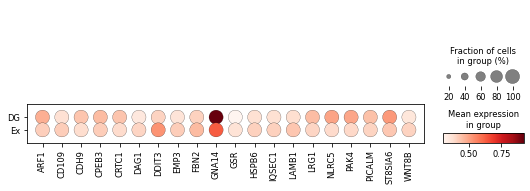

In [145]:
fc=1.1
pvalthresh=0.05
ntopgene=10
desavedir=os.path.join(sampledir,'embedding_'+plottype,'leiden','ExDG'+dename_pred+'DE')
if not os.path.exists(desavedir):
    os.mkdir(desavedir)

#     if featureDE.shape[0]<minCells:
#         continue
topgenes=de_singlesample(predplot[exDGidx],np.array(celltype_broad[exDGidx]),os.path.join(desavedir,'deg'),feature_names,False)
print(topgenes)
np.savetxt(os.path.join(desavedir,'ntop10.txt'),topgenes.astype('str'),fmt='%s')

In [147]:
np.unique(predlabelexDG)

array(['0', '1'], dtype=object)

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0
1
['RGS6' 'NTSR1' 'LYZ2' 'GRM1' 'ARF1' 'PAQR5' 'ABR' 'VWF' 'MIA' 'BIRC5'
 'SLC2A5' 'NDRG1' 'CALCB' 'FLNA' 'RINL' 'GRIK5' 'PAX6' 'KCNMA1' 'CASK'
 'GSTP1']


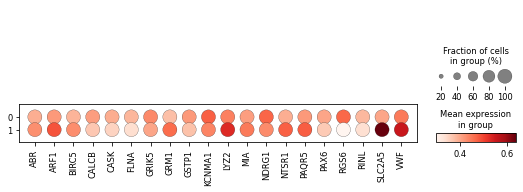

In [149]:
fc=1
pvalthresh=0.05
ntopgene=10
desavedir=os.path.join(sampledir,'embedding_'+plottype,'leiden','ExDG'+dename_pred+'DE_predlabel')
if not os.path.exists(desavedir):
    os.mkdir(desavedir)

#     if featureDE.shape[0]<minCells:
#         continue
topgenes=de_singlesample(predplot[exDGidx],predlabelexDG,os.path.join(desavedir,'deg'),feature_names,False)
print(topgenes)
np.savetxt(os.path.join(desavedir,'ntop10.txt'),topgenes.astype('str'),fmt='%s')

In [377]:
#cluster x recon mean
plotorder=['0','3','4','2','1']
np.random.seed(seed)
samplenameList=np.array([])
for s in plot_samples.keys():
    samplenameList=np.concatenate((samplenameList,np.repeat(s,xlist[s][3].cpu().numpy().shape[0])),axis=None)
samplenameList=samplenameList[exoligodgidx]

for s in plot_samples.keys():
    
    predlabels=predlabelexoligodg[samplenameList==s]
    ctsubsets=celltype_sub[exoligodgidx][samplenameList==s]
#     ctsubsets=ctsubset[exoligodgidx][samplenameList==s]
#     predlabels=predlabels[ctsubsets!='others']
#     ctsubsets=ctsubsets[ctsubsets!='others']
    sampledir=os.path.join(plotsavepath,'combined'+'_clustertranslation_reconMean')
    savedir=os.path.join(sampledir,'embedding_'+plottype,'leiden')

    # savenamecluster='leiden0.005'
    savenamecluster=dename_pred
    res=np.zeros((np.unique(predlabels).size,np.unique(ctsubsets).size))
    for li in range(res.shape[0]):
        l=plotorder[li]
        nl=np.sum(predlabels==l)
        ctsubsets_l=ctsubsets[predlabels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctsubsets)[ci]
            res[li,ci]=np.sum(ctsubsets_l==c)
    #             res[li,ci]=np.sum(ctsubsets_l==c)/nl
    addname='byrow'
    for li in range(res.shape[0]):
        l=np.unique(predlabels)[li]
        nl=np.sum(predlabels==l)
        res[li]=res[li]/nl
    #     else:
    #         addname+='_normbyCT'
    #         for ci in range(res.shape[1]):
    #             c=np.unique(ctsubsets)[ci]
    #             nc=np.sum(ctsubsets==c)
    #             res[:,ci]=res[:,ci]/nc

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    ax.set_yticks(np.arange(np.unique(predlabels).size))
    ax.set_yticklabels(plotorder)
    ax.set_xticks(np.arange(np.unique(ctsubsets).size))
    ax.set_xticklabels(np.unique(ctsubsets))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savedir,savenamecluster+'_clusteragreement_CTexoligodg_'+addname+s+'_pred_sub.jpg'))
    plt.close()

In [326]:
np.sum(predlabelexoligodg=='3')

2114

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


DG
Ex
Oligo
['GNA14' 'HIP1R' 'PCNA' 'CAPZB' 'RGS8' 'SPTAN1' 'CTNND2' 'IL1RAP' 'CPEB2'
 'CLTC' 'VSNL1' 'LRRC7' 'KLHL14' 'SEMA3E' 'IL1RAPL2' 'DDIT4L' 'IFIH1'
 'PAK4' 'GPR17' 'GABRA2' 'P2RY1' 'GSTM1' 'KCND3' 'PLEKHB1' 'CNTNAP4' 'FN1'
 'ATP5G1' 'MANF' 'RINL' 'RERG']


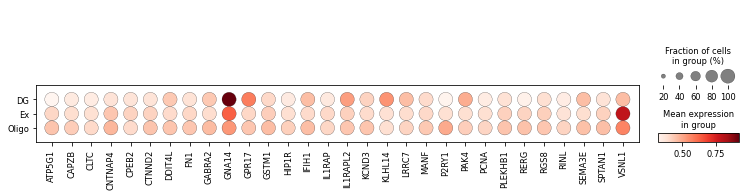

In [218]:
fc=1.1
pvalthresh=0.05
ntopgene=10
desavedir=os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE')
if not os.path.exists(desavedir):
    os.mkdir(desavedir)

#     if featureDE.shape[0]<minCells:
#         continue
topgenes=de_singlesample(predplot[exoligodgidx],np.array(celltype_broad[exoligodgidx]),os.path.join(desavedir,'deg'),feature_names,False)
print(topgenes)
np.savetxt(os.path.join(desavedir,'ntop10.txt'),topgenes.astype('str'),fmt='%s')

/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


DG
Ex
Ol
['GNA14' 'GBP7' 'CPEB2' 'RBP4' 'SPTAN1' 'MATN4' 'UBB' 'VCPIP1' 'FAM20C'
 'BHLHE22' 'DNM1' 'APLN' 'MAG' 'PKM' 'CLDN5' 'NLRC5' 'CADM1' 'FYN'
 'SERPINA3G' 'MAFF' 'P2RY1' 'IL1R1' 'SYNE1' 'KCNF1' 'DLG2' 'BCAT1' 'MARK2'
 'NAV3' 'GSK3B' 'DLX6OS1']


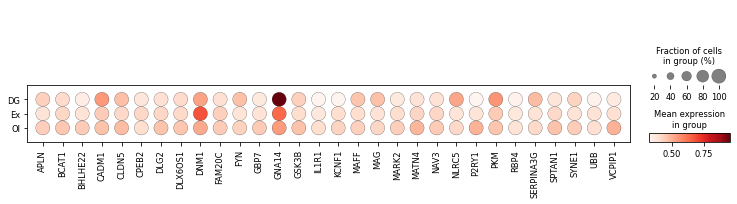

In [36]:
predlabelexoligodgDE=np.repeat('Ex',predlabelexoligodg.size).astype(str)
predlabelexoligodgDE[predlabelexoligodg=='1']='DG'
predlabelexoligodgDE[predlabelexoligodg=='2']='Oligo'
fc=1.1
pvalthresh=0.05
ntopgene=10
desavedir=os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel')
if not os.path.exists(desavedir):
    os.mkdir(desavedir)

#     if featureDE.shape[0]<minCells:
#         continue
topgenes=de_singlesample(predplot[exoligodgidx],predlabelexoligodgDE,os.path.join(desavedir,'deg'),feature_names,False)
print(topgenes)
np.savetxt(os.path.join(desavedir,'ntop10.txt'),topgenes.astype('str'),fmt='%s')

In [75]:
ctrefAllen=pd.read_csv('/home/xinyiz/starmap/trimmed_means.csv')
ctrefAllen.index=np.char.upper(np.array(ctrefAllen['feature'],dtype=str))

In [80]:
refctAllen=[]
for ct in ctrefAllen.columns:
    if ('L2' in ct and 'CTX' in ct) or ('L3' in ct and 'CTX' in ct) or ('L4' in ct and 'CTX' in ct) or ('L5' in ct and 'CTX' in ct) or ('L6' in ct and 'CTX' in ct) or ('Oligo' in ct) or ('DG' in ct):
#         if 'CTX' in ct:
#             refctAllen.append('Ex('+ct+')')
#         else:
        refctAllen.append(ct)
refctAllen=np.sort(refctAllen)

In [81]:
_,degexistidx,_=np.intersect1d(deg_predlabel_list,ctrefAllen.index,return_indices=True)
ctrefAllen_sub=ctrefAllen[refctAllen]
ctrefgidx=np.zeros(deg_predlabel_list.size)
for g in range(deg_predlabel_list.size):
    if np.sum(ctrefAllen.index==deg_predlabel_list[g])==0:
        continue
    ctrefgidx[g]=np.where(ctrefAllen.index==deg_predlabel_list[g])[0][0]
ctrefAllen_sub=np.array(ctrefAllen_sub)[ctrefgidx.astype(int)]


In [41]:
predgidx=np.zeros(deg_predlabel_list.size)
for g in range(deg_predlabel_list.size):
    predgidx[g]=np.where(feature_names==deg_predlabel_list[g])[0][0]
predgidx=predgidx.astype(int)
res=np.copy(predplot[exoligodgidx][:,predgidx])
res=(res-np.repeat(np.min(res,axis=0).reshape(1,-1),res.shape[0],axis=0))/(np.repeat(np.max(res,axis=0).reshape(1,-1),res.shape[0],axis=0)-np.repeat(np.min(res,axis=0).reshape(1,-1),res.shape[0],axis=0))
res=res[np.concatenate((np.concatenate((np.concatenate((np.where(predlabelexoligodg=='0')[0],np.where(predlabelexoligodg=='3')[0])),np.concatenate((np.where(predlabelexoligodg=='4')[0],np.where(predlabelexoligodg=='2')[0])))),np.where(predlabelexoligodg=='1')[0]))]


In [42]:
resl2=np.linalg.norm(res,ord=2,axis=1)
refl2=np.linalg.norm(ctrefAllen_sub,ord=2,axis=0)

In [43]:
cosDEG=res @ ctrefAllen_sub
cosDEG=cosDEG/resl2.reshape(-1,1)
cosDEG=cosDEG/refl2

In [45]:
cosDEGnorm=(cosDEG-np.repeat(np.min(cosDEG,axis=0).reshape(1,-1),cosDEG.shape[0],axis=0))/(np.repeat(np.max(cosDEG,axis=0).reshape(1,-1),cosDEG.shape[0],axis=0)-np.repeat(np.min(cosDEG,axis=0).reshape(1,-1),cosDEG.shape[0],axis=0))

In [87]:
refctAllenplot=[]
for i in refctAllen:
    if 'CTX' in i:
        refctAllenplot.append('Ex ('+i+')')
    else:
        refctAllenplot.append(i)
refctAllenplot=np.array(refctAllenplot)

In [46]:
exavg=np.mean(cosDEGnorm[:np.sum(predlabelexoligodg=='0')+np.sum(predlabelexoligodg=='3')+np.sum(predlabelexoligodg=='4')],axis=0)
exavgmax=np.argsort(-exavg)

In [47]:
exavg[np.argsort(-exavg)][:5]

array([0.77737616, 0.76672494, 0.76339356, 0.76193298, 0.75981797])

In [493]:
refctAllen[exavgmax]

array(['249_L5 PT CTX', '187_L4/5 IT CTX', '199_L5 IT CTX',
       '201_L5 IT CTX', '250_L5 PT CTX', '181_L4 IT CTX',
       '204_L5/6 IT CTX', '178_L4 IT CTX', '202_L5 IT CTX',
       '269_L5/6 NP CTX', '168_L2/3 IT CTX', '188_L4/5 IT CTX',
       '206_L5/6 IT CTX', '184_L4/5 IT CTX', '197_L5 IT CTX',
       '191_L4/5 IT CTX', '200_L5 IT CTX', '189_L4/5 IT CTX',
       '180_L4 IT CTX', '183_L4/5 IT CTX', '182_L4/5 IT CTX',
       '203_L5/6 IT CTX', '190_L4/5 IT CTX', '205_L5/6 IT CTX',
       '198_L5 IT CTX', '167_L2/3 IT CTX', '260_L5 PT CTX',
       '170_L2/3 IT CTX', '209_L5/6 IT CTX', '171_L2/3 IT CTX',
       '207_L5/6 IT CTX', '252_L5 PT CTX', '185_L4/5 IT CTX',
       '244_L5 PT CTX', '169_L2/3 IT CTX', '264_L5/6 NP CTX',
       '192_L4/5 IT CTX', '259_L5 PT CTX', '193_L4/5 IT CTX',
       '286_L6 CT CTX', '292_L6 CT CTX', '208_L5/6 IT CTX',
       '196_L5 IT CTX', '291_L6 CT CTX', '247_L5 PT CTX', '248_L5 PT CTX',
       '315_L6b CTX', '289_L6 CT CTX', '179_L4 IT CTX', '313_L6

In [82]:
oligoavg=np.mean(cosDEGnorm[np.sum(predlabelexoligodg=='0')+np.sum(predlabelexoligodg=='3')+np.sum(predlabelexoligodg=='4'):np.sum(predlabelexoligodg=='0')+np.sum(predlabelexoligodg=='3')+np.sum(predlabelexoligodg=='4')+np.sum(predlabelexoligodg=='2')],axis=0)
oligoavgmax=np.argsort(-oligoavg)

(array([0, 1]), [Text(0, 0, 'Ex (249_L5 PT CTX)'), Text(1, 0, '365_Oligo')])

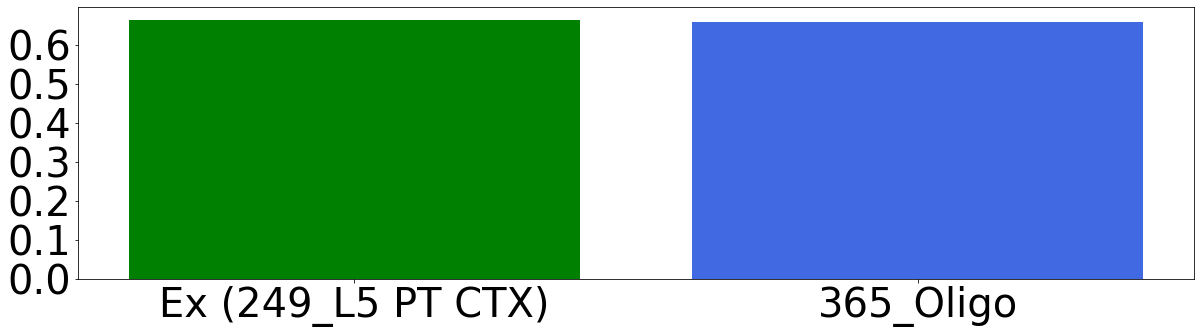

In [89]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.bar([0,1],oligoavg[oligoavgmax][:2],width=0.8,tick_label=refctAllenplot[oligoavgmax][:2],color=['green','royalblue'])
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)

In [495]:
refctAllen[oligoavgmax]

array(['249_L5 PT CTX', '365_Oligo', '250_L5 PT CTX', '206_L5/6 IT CTX',
       '199_L5 IT CTX', '202_L5 IT CTX', '205_L5/6 IT CTX',
       '244_L5 PT CTX', '191_L4/5 IT CTX', '187_L4/5 IT CTX',
       '200_L5 IT CTX', '315_L6b CTX', '190_L4/5 IT CTX', '201_L5 IT CTX',
       '252_L5 PT CTX', '207_L5/6 IT CTX', '182_L4/5 IT CTX',
       '183_L4/5 IT CTX', '181_L4 IT CTX', '259_L5 PT CTX',
       '245_L5 PT CTX', '260_L5 PT CTX', '188_L4/5 IT CTX',
       '204_L5/6 IT CTX', '208_L5/6 IT CTX', '192_L4/5 IT CTX',
       '219_L6 IT CTX', '248_L5 PT CTX', '198_L5 IT CTX', '197_L5 IT CTX',
       '366_Oligo', '167_L2/3 IT CTX', '254_L5 PT CTX', '203_L5/6 IT CTX',
       '168_L2/3 IT CTX', '367_Oligo', '247_L5 PT CTX', '313_L6b CTX',
       '251_L5 PT CTX', '193_L4/5 IT CTX', '209_L5/6 IT CTX',
       '196_L5 IT CTX', '243_L5 PT CTX', '257_L5 PT CTX',
       '185_L4/5 IT CTX', '165_L2/3 IT CTX', '312_L6b CTX',
       '218_L6 IT CTX', '178_L4 IT CTX', '224_L6 IT CTX', '314_L6b CTX',
       '18

In [91]:
dgavg=np.mean(cosDEGnorm[-np.sum(predlabelexoligodg=='1'):],axis=0)
dgavgmax=np.argsort(-dgavg)

(array([0, 1]), [Text(0, 0, '361_DG'), Text(1, 0, '363_DG')])

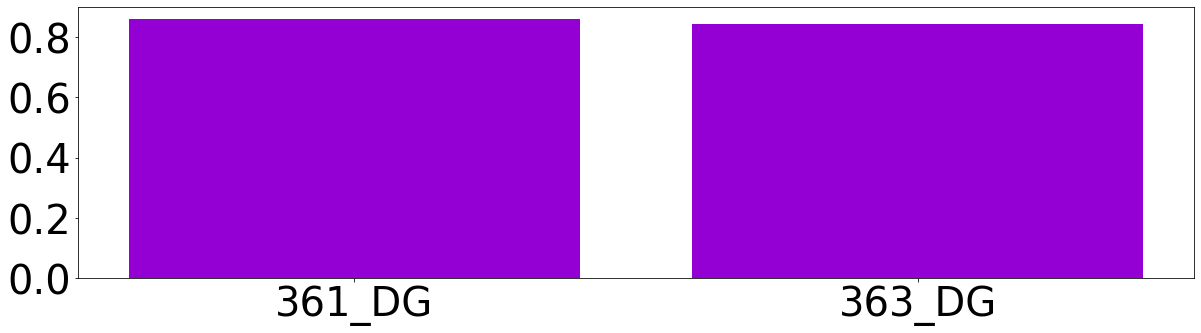

In [93]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.bar([0,1],dgavg[dgavgmax][:2],width=0.8,tick_label=refctAllenplot[dgavgmax][:2],color=['darkviolet','darkviolet'])
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)

In [501]:
np.savetxt(os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','cosExAllenDescending.csv'),refctAllen[exavgmax],fmt='%s')
np.savetxt(os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','cosDGAllenDescending.csv'),refctAllen[dgavgmax],fmt='%s')
np.savetxt(os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','cosOligoAllenDescending.csv'),refctAllen[oligoavgmax],fmt='%s')

(array([0, 1]),
 [Text(0, 0, 'Ex (249_L5 PT CTX)'), Text(1, 0, 'Ex (187_L4/5 IT CTX)')])

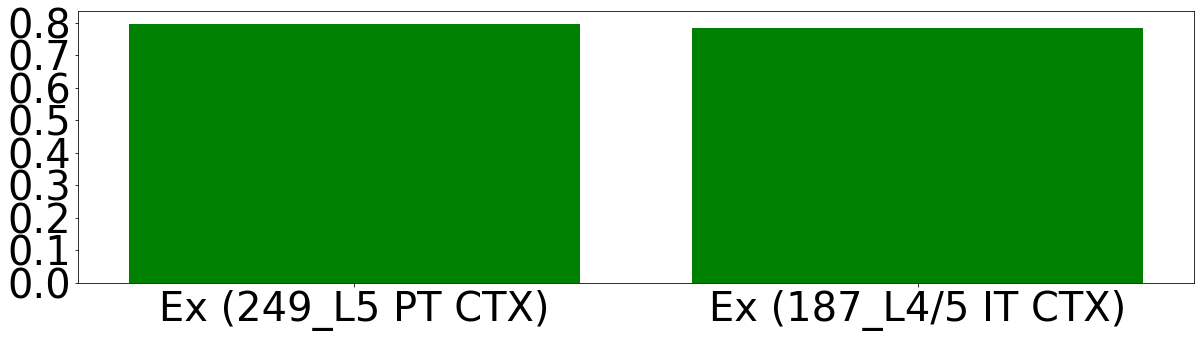

In [94]:
exavg1=np.mean(cosDEGnorm[:np.sum(predlabelexoligodg=='0')],axis=0)
exavgmax1=np.argsort(-exavg1)
fig, ax = plt.subplots(figsize=(20, 5))
plt.bar([0,1],exavg1[exavgmax1][:2],width=0.8,tick_label=refctAllenplot[exavgmax1][:2],color=['green','green'])
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)


(array([0, 1]),
 [Text(0, 0, 'Ex (249_L5 PT CTX)'), Text(1, 0, 'Ex (178_L4 IT CTX)')])

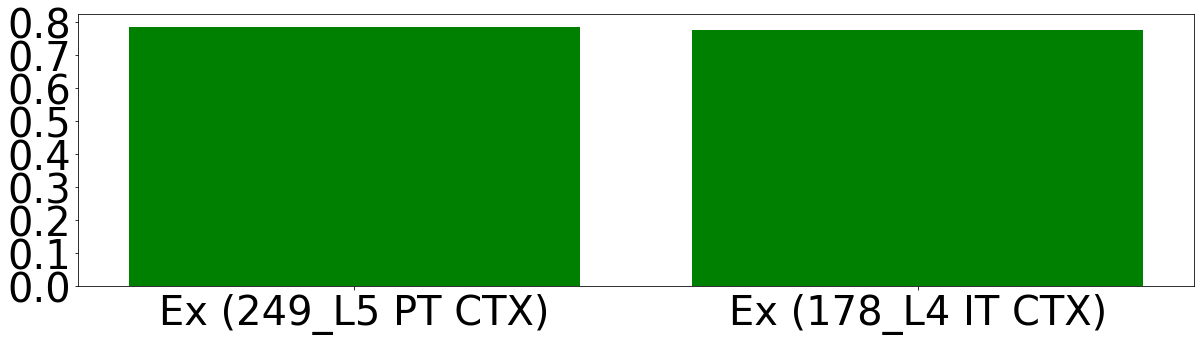

In [95]:
exavg2=np.mean(cosDEGnorm[np.sum(predlabelexoligodg=='0'):np.sum(predlabelexoligodg=='0')+np.sum(predlabelexoligodg=='3')],axis=0)
exavgmax2=np.argsort(-exavg2)
fig, ax = plt.subplots(figsize=(20, 5))
plt.bar([0,1],exavg2[exavgmax2][:2],width=0.8,tick_label=refctAllenplot[exavgmax2][:2],color=['green','green'])
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)


(array([0, 1]),
 [Text(0, 0, 'Ex (249_L5 PT CTX)'), Text(1, 0, 'Ex (201_L5 IT CTX)')])

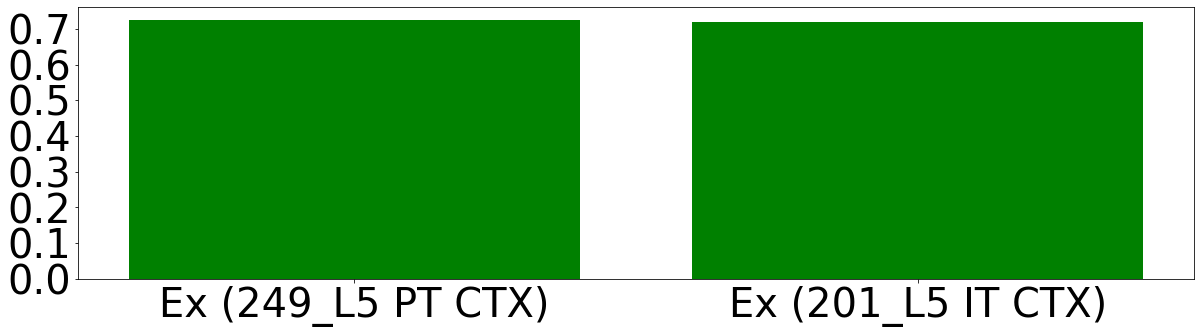

In [96]:
exavg3=np.mean(cosDEGnorm[np.sum(predlabelexoligodg=='0')+np.sum(predlabelexoligodg=='3'):np.sum(predlabelexoligodg=='0')+np.sum(predlabelexoligodg=='3')+np.sum(predlabelexoligodg=='4')],axis=0)
exavgmax3=np.argsort(-exavg3)
fig, ax = plt.subplots(figsize=(20, 5))
plt.bar([0,1],exavg3[exavgmax3][:2],width=0.8,tick_label=refctAllenplot[exavgmax3][:2],color=['green','green'])
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)


In [508]:
np.savetxt(os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','coscluster0AllenDescending.csv'),refctAllen[exavgmax1],fmt='%s')
np.savetxt(os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','coscluster3AllenDescending.csv'),refctAllen[exavgmax2],fmt='%s')
np.savetxt(os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','coscluster4AllenDescending.csv'),refctAllen[exavgmax3],fmt='%s')

In [513]:
import gseapy as gp

Creating directory /home/xinyiz/.config/bioservices 


In [523]:
geneset={'Ex':[],'Oligo':[],'DG':[]}
for ct in ctrefAllen.columns:
    if ('L2' in ct and 'CTX' in ct) or ('L3' in ct and 'CTX' in ct) or ('L4' in ct and 'CTX' in ct) or ('L5' in ct and 'CTX' in ct) or ('L6' in ct and 'CTX' in ct):
        geneset['Ex'].append(ct)
    elif 'Oligo' in ct:
        geneset['Oligo'].append(ct)
    elif 'DG' in ct:
        geneset['DG'].append(ct)

In [535]:
len(geneset['Oligo'])

11

In [525]:
gseaex1=gp.prerank(rnk=pd.DataFrame(data={'ct':refctAllen,'rank':exavg1}), gene_sets=geneset,min_size=0,
                   outdir=os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','cluster0GSEA'), format='jpg', seed=6)

In [527]:
gseaex2=gp.prerank(rnk=pd.DataFrame(data={'ct':refctAllen,'rank':exavg2}), gene_sets=geneset,min_size=0,
                   outdir=os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','cluster3GSEA'), format='jpg', seed=6)

In [528]:
gseaex3=gp.prerank(rnk=pd.DataFrame(data={'ct':refctAllen,'rank':exavg3}), gene_sets=geneset,min_size=0,
                   outdir=os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','cluster4GSEA'), format='jpg', seed=6)

In [529]:
gseaoligo=gp.prerank(rnk=pd.DataFrame(data={'ct':refctAllen,'rank':oligoavg}), gene_sets=geneset,min_size=0,
                   outdir=os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','cluster2GSEA'), format='jpg', seed=6)

In [530]:
gseadg=gp.prerank(rnk=pd.DataFrame(data={'ct':refctAllen,'rank':dgavg}), gene_sets=geneset,min_size=0,
                   outdir=os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','cluster1GSEA'), format='jpg', seed=6)

In [419]:
for ct in ['Ex','Ol','DG']:
    print(np.intersect1d(np.char.upper(np.array(ctrefAllen['feature'],dtype=str)),deg_predlabel[ct]).size)
    print(deg_predlabel[ct].size)

170
170
914
914
642
643


In [37]:
sampledir=os.path.join(plotsavepath,'combined'+'_clustertranslation_reconMean')
desavedir=os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel')
fc=1.1
pvalthresh=0.05
deg_predlabel={}
deg_predlabel_list=np.array([])
for ct in ['Ex','Ol','DG']:
    deg_predlabel[ct]=np.loadtxt(os.path.join(desavedir,'deg'+'UP_'+ct+'_fc'+str(fc)+'pvalue'+str(pvalthresh)+'.csv'),dtype=str)
    deg_predlabel_list=np.concatenate((deg_predlabel_list,deg_predlabel[ct]))
    

In [410]:
deg_predlabel

{'Ex': array(['DNM1', 'SNAP25', 'VSNL1', 'RAB6B', 'EPN1', 'GPM6A', 'RASGRP1',
        'PDE1A', 'ATP1A3', 'DDIT3', 'DBN1', 'KLF6', 'PPP2R1A', 'PPP3R1',
        'DKK3', 'SYT11', 'PFN2', 'DNAJC5', 'BSN', 'PFKP', 'DGKB', 'HUNK',
        'CPLX1', 'ALDH3B2', 'CNKSR2', 'PAK1', 'PAFAH1B1', 'STMN2', 'FLOT2',
        'YWHAQ', 'PRKCB', 'RAB1A', 'SOX9', 'KIF5A', 'SLC6A2', 'CABLES1',
        'PRSS56', 'GRIN2D', 'ANPEP', 'ELFN1', 'WNT2', 'LYPD1', 'PTGFR',
        'ITPKA', 'PTX3', 'ERBB4', 'PRIM1', 'PPP1R3G', 'RGS6', 'CXCL5',
        'ST8SIA2', 'RPH3A', 'C1QA', 'CACNA1B', 'SST', 'ADGRB1', 'SCN1B',
        'STAU2', 'TMSB10', 'IRX6', 'AGTR2', 'ITGA4', 'PCDH9', 'MREG',
        'TRPC5', 'QDPR', 'TFAP2B', 'CUX2', 'RSPH1', 'HPCA', 'CLDN11',
        'HMMR', 'SLITRK3', 'RAB11A', 'HSD17B12', 'SCN4B', 'EFHD2', 'GRM3',
        'SAG', 'NGDN', 'NLGN2', 'BRCA1', 'ROBO1', 'EPS8', 'RSPO3',
        'COL18A1', 'CHRNB2', 'KCNJ9', 'CCL19', 'TSPAN5', 'H2-EB1', 'UBB',
        'PAM', 'C5AR1', 'EMP3', 'MOB3B', 'LHX1OS', 'NA

In [307]:
ref64gene={'Ex':['SLC17A7','CUX2','TSHZ2','CPLX1','PCP4','PCDH9','VSNL1', 'SNAP25', 'DNM1'],
          'Ol':['PLP1','MBP','CLDN11','KLK6','C4B','CDKN1A'],
          'DG':['C1QL3']} #added genes mentioned in paper


In [273]:
desavedir

'/mnt/external_ssd/xinyi/plots/train_jointGAEcnn_starmap/allnoC8_thresh25_02_mse100_sm5x/combined_clustertranslation_reconMean/embedding_umap/leiden/ExOligoDGleiden0.2DE_predlabel'

In [272]:
desavedir=os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel')
with open(os.path.join(desavedir,'deg'),'rb') as deread:
    deres=pickle.load(deread)

In [286]:
var = pd.DataFrame(data=feature_names,index=feature_names,columns=['feature_names'])
adata = ad.AnnData(var=var.astype('category'))
adata.uns['rank_genes_groups']=deres
resl=scanpy.get.rank_genes_groups_df(adata, group='Ex',pval_cutoff=1,gene_symbols='feature_names')
resl

,names,scores,logfoldchanges,pvals,pvals_adj,feature_names,pct_nz_group,pct_nz_reference
0,DNM1,101.154610,0.497898,0.0,0.0,DNM1,1.0,1.0
1,SNAP25,101.019447,0.756214,0.0,0.0,SNAP25,1.0,1.0
2,VSNL1,99.311310,0.934128,0.0,0.0,VSNL1,1.0,1.0
3,RAB6B,96.800690,0.480870,0.0,0.0,RAB6B,1.0,1.0
4,EPN1,96.618637,0.339418,0.0,0.0,EPN1,1.0,1.0
...,...,...,...,...,...,...,...,...
2107,COL24A1,-100.274414,-0.514934,0.0,0.0,COL24A1,1.0,1.0
2108,KCNA4,-100.483543,-0.443047,0.0,0.0,KCNA4,1.0,1.0
2109,HNRNPH1,-100.893219,-0.379688,0.0,0.0,HNRNPH1,1.0,1.0
2110,INPP4B,-101.244064,-0.434153,0.0,0.0,INPP4B,1.0,1.0


In [357]:
np.where(predlabelexoligodg=='0')[0].shape

(4609,)

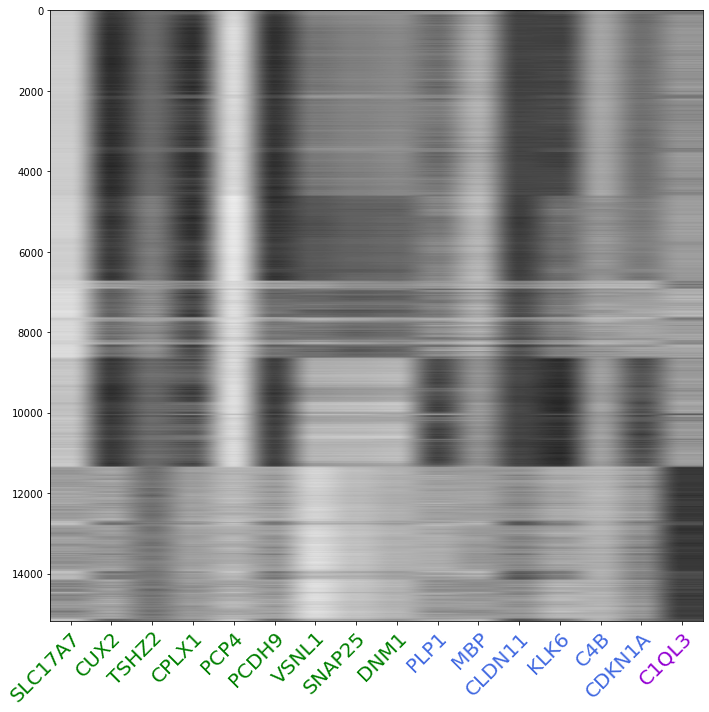

In [386]:
allrefgenes=np.array([])
refgene_colors=np.array([])
colordictgenes={'Ex':'green','Ol':'royalblue','DG':'darkviolet'}
for ct in ref64gene.keys():
    allrefgenes=np.concatenate((allrefgenes,ref64gene[ct]))
    refgene_colors=np.concatenate((refgene_colors,np.repeat(colordictgenes[ct],len(ref64gene[ct]))))
origdegidx=np.zeros(allrefgenes.size)
for g in range(allrefgenes.size):
    origdegidx[g]=np.where(feature_names==allrefgenes[g])[0][0]
origdegidx=origdegidx.astype(int)
res=np.copy(predplot[exoligodgidx][:,origdegidx])
res=(res-np.repeat(np.min(res,axis=0).reshape(1,-1),res.shape[0],axis=0))/(np.repeat(np.max(res,axis=0).reshape(1,-1),res.shape[0],axis=0)-np.repeat(np.min(res,axis=0).reshape(1,-1),res.shape[0],axis=0))
res=res[np.concatenate((np.concatenate((np.concatenate((np.where(predlabelexoligodg=='0')[0],np.where(predlabelexoligodg=='3')[0])),np.concatenate((np.where(predlabelexoligodg=='4')[0],np.where(predlabelexoligodg=='2')[0])))),np.where(predlabelexoligodg=='1')[0]))]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(res,cmap='binary',aspect='auto')
# ax.set_yticks(np.arange(np.unique(mulabel).size))
# ax.set_yticklabels(np.unique(mulabel))
ax.set_xticks(np.arange(allrefgenes.size))
ax.set_xticklabels(allrefgenes,fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), refgene_colors):
    ticklabel.set_color(tickcolor)

fig.tight_layout()
plt.savefig(os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','heatmap.jpg'))

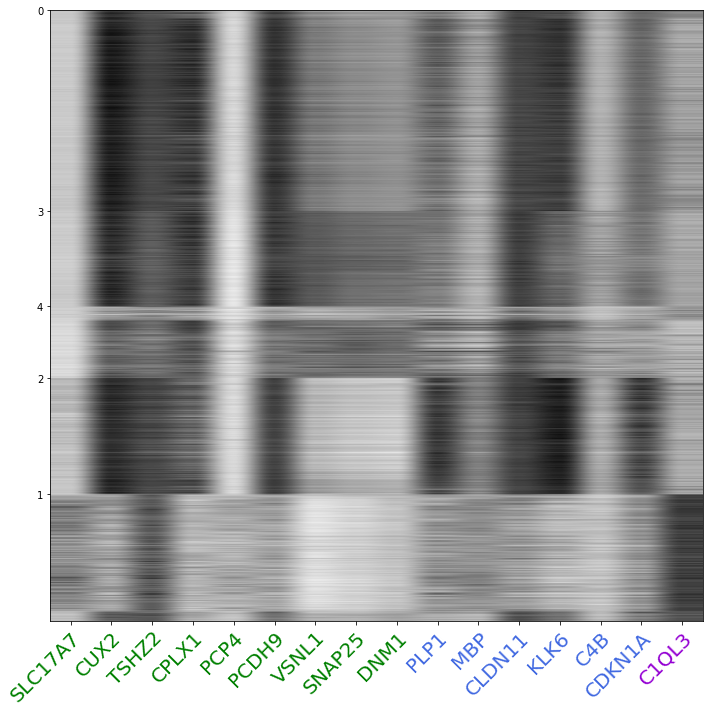

In [548]:
allrefgenes=np.array([])
refgene_colors=np.array([])
colordictgenes={'Ex':'green','Ol':'royalblue','DG':'darkviolet'}
for ct in ref64gene.keys():
    allrefgenes=np.concatenate((allrefgenes,ref64gene[ct]))
    refgene_colors=np.concatenate((refgene_colors,np.repeat(colordictgenes[ct],len(ref64gene[ct]))))
origdegidx=np.zeros(allrefgenes.size)
for g in range(allrefgenes.size):
    origdegidx[g]=np.where(feature_names==allrefgenes[g])[0][0]
origdegidx=origdegidx.astype(int)
res=np.copy(predplot[samplenameList=='control8'][exoligodgidx[samplenameList=='control8']][:,origdegidx])
res=(res-np.repeat(np.min(res,axis=0).reshape(1,-1),res.shape[0],axis=0))/(np.repeat(np.max(res,axis=0).reshape(1,-1),res.shape[0],axis=0)-np.repeat(np.min(res,axis=0).reshape(1,-1),res.shape[0],axis=0))
res=res[np.concatenate((np.concatenate((np.concatenate((np.where(predlabelexoligodg[samplenameList[exoligodgidx]=='control8']=='0')[0],np.where(predlabelexoligodg[samplenameList[exoligodgidx]=='control8']=='3')[0])),np.concatenate((np.where(predlabelexoligodg[samplenameList[exoligodgidx]=='control8']=='4')[0],np.where(predlabelexoligodg[samplenameList[exoligodgidx]=='control8']=='2')[0])))),np.where(predlabelexoligodg[samplenameList[exoligodgidx]=='control8']=='1')[0]))]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(res,cmap='binary',aspect='auto')
nc0=np.sum(predlabelexoligodg[samplenameList[exoligodgidx]=='control8']=='0')
nc3=np.sum(predlabelexoligodg[samplenameList[exoligodgidx]=='control8']=='3')
nc4=np.sum(predlabelexoligodg[samplenameList[exoligodgidx]=='control8']=='4')
nc2=np.sum(predlabelexoligodg[samplenameList[exoligodgidx]=='control8']=='2')

ax.set_yticks([0,nc0,nc0+nc3,nc0+nc3+nc4,nc0+nc3+nc4+nc2])
ax.set_yticklabels(['0','3','4','2','1'])
ax.set_xticks(np.arange(allrefgenes.size))
ax.set_xticklabels(allrefgenes,fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), refgene_colors):
    ticklabel.set_color(tickcolor)

fig.tight_layout()
plt.savefig(os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','heatmap_c8.jpg'))

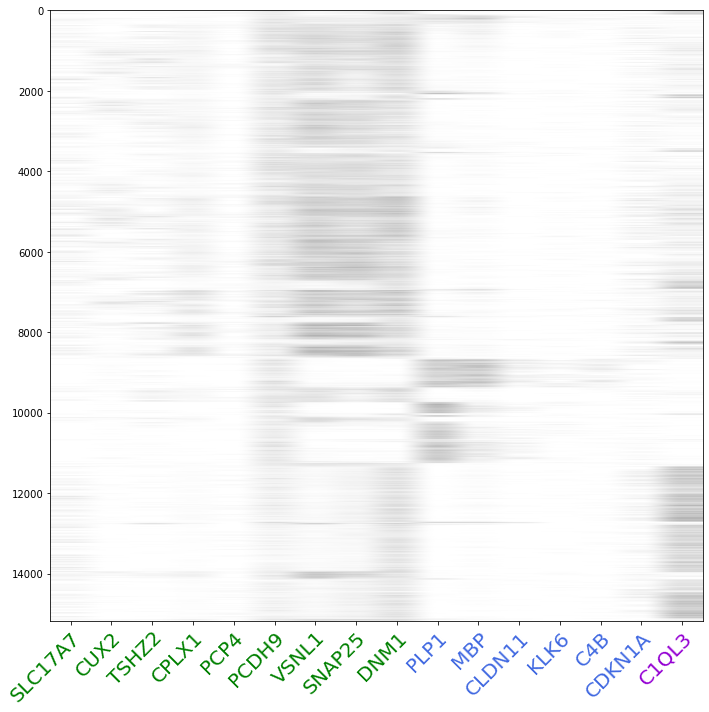

In [389]:
allrefgenes=np.array([])
for ct in ref64gene.keys():
    allrefgenes=np.concatenate((allrefgenes,ref64gene[ct]))
origdegidx=np.zeros(allrefgenes.size)
for g in range(allrefgenes.size):
    origdegidx[g]=np.where(feature_names==allrefgenes[g])[0][0]
origdegidx=origdegidx.astype(int)
res=np.copy(featureDE[exoligodgidx][:,origdegidx])
res=(res-np.repeat(np.min(res,axis=0).reshape(1,-1),res.shape[0],axis=0))/(np.repeat(np.max(res,axis=0).reshape(1,-1),res.shape[0],axis=0)-np.repeat(np.min(res,axis=0).reshape(1,-1),res.shape[0],axis=0))
res=res[np.concatenate((np.concatenate((np.concatenate((np.where(predlabelexoligodg=='0')[0],np.where(predlabelexoligodg=='3')[0])),np.concatenate((np.where(predlabelexoligodg=='4')[0],np.where(predlabelexoligodg=='2')[0])))),np.where(predlabelexoligodg=='1')[0]))]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(res,cmap='binary',aspect='auto')
# ax.set_yticks(np.arange(np.unique(mulabel).size))
# ax.set_yticklabels(np.unique(mulabel))
ax.set_xticks(np.arange(allrefgenes.size))
ax.set_xticklabels(allrefgenes,fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), refgene_colors):
    ticklabel.set_color(tickcolor)
fig.tight_layout()
plt.savefig(os.path.join(sampledir,'embedding_'+plottype,'leiden','ExOligoDG'+dename_pred+'DE_predlabel','heatmap_origraw.jpg'))

In [376]:
# plotorder=['0','3','4','2','1']
# predlabelexoligodgPlotorder=np.copy(predlabelexoligodg)
# startidx=1
# for c in plotorder:
#     predlabelexoligodgPlotorder[predlabelexoligodg==c]=str(startidx)
#     startidx+=1
# n_neighbors=10
# min_dist=0.25
savedir=os.path.join(sampledir,'embedding_'+plottype,'leiden')
# reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
# embedding = reducer.fit_transform(predplot[exoligodgidx])
# savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
# plotembeddingbyCT(predlabelexoligodgPlotorder,'predlabel',[],embedding,savedir,plottype+'of all samples',savenameAdd='combinedClusterExoligodg_res0.2',plotdimx=0,plotdimy=1)
# plotembeddingbyCT(samplenameList[exoligodgidx],'sample',[],embedding,savedir,plottype+'of all samples',savenameAdd='combinedClusterExoligodg_res0.2',plotdimx=0,plotdimy=1)
for s in plot_samples:
    sidx=samplenameList[exoligodgidx]==s
    plotembeddingbyCT(predlabelexoligodgPlotorder[sidx],'location',[],cellCoord[s][exoligodgidx[samplenameList==s]],savedir,plottype+'of all samples',savenameAdd=s+'_combinedClusterExoligodg_res0.2',plotdimx=0,plotdimy=1)
